<a href="https://colab.research.google.com/github/juoll/data_analyst_test_technique/blob/main/etudes/notebooks/DTAM-807/feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install imgaug==0.2.5 --force-reinstall
#!yes|pip install --quiet git+https://github.com/christophM/rulefit.git
#!yes|pip install --quiet git+https://github.com/SauceCat/PDPbox.git
#!pip install folktables==0.0.11 catboost==1.1.1 imodels==1.3.0 interpret==0.2.7 shap==0.37.0 PyALE==1.1.2 lime==0.2.0.1
!pip install catboost imodels shap lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import plotly.express as px
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
#from kneed import KneeLocator
import plotly.express as px

from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
#from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import Pipeline, make_pipeline 
from sklearn.metrics import roc_auc_score, average_precision_score, make_scorer, balanced_accuracy_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV, HalvingGridSearchCV
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.metrics import RocCurveDisplay


import math
import os
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=DeprecationWarning)

#DATA WRANGLING
import numpy as np
import pandas as pd
#from folktables import ACSDataSource, ACSEmployment
from sklearn.model_selection import train_test_split

#MODELING
from tqdm.notebook import trange, tqdm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics, linear_model, tree, naive_bayes, neighbors, ensemble, neural_network
import catboost as cb
#from rulefit import RuleFit
from imodels import FIGSClassifier
#from interpret.glassbox import ExplainableBoostingClassifier

#VISUALIZATION & INTERPRETATION
import matplotlib.pyplot as plt
import seaborn as sns
#from interpret import show
#from pdpbox import pdp, info_plots
#from PyALE import ale
from lime.lime_tabular import LimeTabularExplainer
import shap


%config InlineBackend.figure_format = 'retina' # Make visualizations look good
#%config InlineBackend.figure_format = 'svg' 
%matplotlib inline
import sys

#if 'google.colab' in sys.modules:
#  !pip install -q dtreeviz

In [ ]:
# paramétrage
pd.options.display.max_columns = None
pd.options.display.width = 1000
pd.options.display.max_seq_items = None
warnings.filterwarnings('ignore')

In [ ]:
def downcast(data):
    for col in data.columns:
        if data[col].dtype == "int64":
            data[col] = pd.to_numeric(data[col], downcast="integer")
        if data[col].dtype == "float64":
            data[col] = pd.to_numeric(data[col], downcast="float")

In [ ]:
def get_id_if_exist(folder_id, file_name):
  file_list = drive.ListFile({'q':"'"+ folder_id +"'  in parents and trashed=False"}).GetList()
  for x in range(len(file_list)):
    if file_list[x]['title'] == file_name:
      return file_list[x]['id']

In [ ]:
#Applying multicollinearity to remove columns which are dependent on each other
# From looking at documentation, values between 5 and 10 are "okay".
# Above 10 is too high and so should be removed.
from statsmodels.stats.outliers_influence import variance_inflation_factor

class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=10, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = SimpleImputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

In [ ]:
def create_gfile(folder_id, filename):
  existing_id = get_id_if_exist(folder_id, filename)
  if existing_id:
      return drive.CreateFile({'id':existing_id})
  else:
      return drive.CreateFile({'parents': [{'id': folder_id}]})

In [ ]:
# Authentification et instantitaion client google drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Récupération du CSV depuis le drive
dl = drive.CreateFile({'id':'1bcUu97hLI2SPidQArfE3aOGkBXSEtm9X'})
dl.GetContentFile('engineered-dataset.csv')  
df = pd.read_csv('engineered-dataset.csv')

In [ ]:
df=df.fillna(0)
df.replace([np.inf, -np.inf], 0, inplace=True)
df['ENT_CAT_JUR_NIV1']=df['ENT_CAT_JUR_NIV1'].round(0).astype(str)
df['CAB_CAT_JUR_NIV2']=df['CAB_CAT_JUR_NIV2'].round(0).astype(str)
df.head(5)

ENT_LIC ENT_TYPE_CAP ENT_REG_FISC ENT_REG_IMP ENT_FORM_JUR  ENT_TYPE_TVA          ENT_ACT_TVA           ENT_REG_TVA ENT_TYPE_COMPTA ENT_TYPE_PACK_LIC ENT_SECT_ACT ENT_EFFECTIF ENT_CAT_ENT ENT_ETAT_ADM ENT_CAR_EMP ENT_SEC_NAF ENT_CAT_JUR_NIV1      CAB_TYPE_ACT  CAB_HAS_PERSO  CAB_SITE_ORGA  CAB_NB_PREM_DIS  CAB_MT_PREM_HONO  CAB_AGE_CAB CAB_EFFECTIF CAB_CAT_ENT CAB_ETAT_ADM CAB_CAR_EMP CAB_SEC_NAF  CAB_DIV_NAF CAB_CAT_JUR_NIV2  NB_HITS_ACH  NB_HITS_EXP  NB_HITS_NDF  NB_HITS_TDB  NB_HITS_FAC  NB_HITS_CAI  NB_HITS_BAT  TAUX_AFFECTATION  CAT_AGE_SINCE_FIRST_PACK  CAT_AGE_SINCE_SECOND_PACK  CAT_AGE_SINCE_LAST_PACK  CAT_NB_COMMANDES_SUR_2_ANS  CAT_ENT_AGE_EDITION  ENT_GEO_CLUSTER
0  PREMIUM       SOCIAL          BNC          IR           EI  ENCAISSEMENT  PRESTATION_SERVICES    SIMPLIFIE_ANNUELLE      TRESORERIE           PACK_10     SERVICES           NN         PME            A           O           P              1.0  EXPERT_COMPTABLE          False          False               37             335.0          206           12         PME            A           O           M         69.0             54.0          0.0          2.0          0.0          0.0          0.0          0.0          0.0          0.891892                       2.0                        2.0                      1.0                         0.0                  0.0                0
1     FREE       SOCIAL          BIC          IR           EI  ENCAISSEMENT  PRESTATION_SERVICES  NORMAL_TRIMESTRIELLE      ENGAGEMENT           PACK_10     SERVICES           NN         PME            A           N           L              1.0  EXPERT_COMPTABLE          False          False               24             225.0          386           NN         ETI            C           N           M         69.0             55.0          0.0          0.0          0.0          0.0         16.0          0.0          0.0          0.500000                       3.0                        3.0                      0.0                         0.0                  0.0               -1
2     FREE       SOCIAL          BIC          IS           SA  ENCAISSEMENT  PRESTATION_SERVICES      NORMAL_MENSUELLE      ENGAGEMENT           PACK_10        AUTRE           11         PME            C           O           J              5.0  EXPERT_COMPTABLE           True          False               16             200.0          129           NN         PME            A           N           M         69.0             57.0          0.0          6.0          0.0          0.0         92.0          0.0          0.0          0.812500                       3.0                        3.0                      1.0                         0.0                  2.0                1
3     FREE       SOCIAL          BIC          IR         CUMA  ENCAISSEMENT  PRESTATION_SERVICES    SIMPLIFIE_ANNUELLE      ENGAGEMENT           PACK_10     SERVICES           01         PME            A           N           N              6.0  EXPERT_COMPTABLE          False          False                6              50.0          554           32         ETI            A           O           M         69.0             92.0          0.0          2.0          0.0          0.0        259.0          0.0          0.0          0.333333                       3.0                       -1.0                      3.0                         0.0                  1.0                0
4     FREE       SOCIAL          BIC          IS         SARL  ENCAISSEMENT  PRESTATION_SERVICES      NORMAL_MENSUELLE      ENGAGEMENT           PACK_10     SERVICES           02         PME            A           O           M              5.0  EXPERT_COMPTABLE          False          False                0               0.0          359           02         PME            A           O           M         69.0             54.0          0.0          4.0          0.0          0.0       1474.0          0.0          0.0          0.000000                      -1.0      

In [ ]:
df['ENT_LIC_BIN']=df['ENT_LIC'].replace({'FREE': 0, 'PREMIUM': 1})

# 🤖 Feature selection

> Feature selection is the process of eliminating "non-informative" features.

👇 There are 2 main types of statistical feature selection:

- Univariate feature selection → Feature Correlation (Univariate)
- Multivariate → Features' multicollinearity (Multivariate)

Why feature selection?
- 🚮 Garbage in → garbage out
- 💥 The curse of dimensionality
- 🤯 Reducing complexity

## 🚮 Garbage in → garbage out
Poor quality input will:
- Induce noise
- Destabilize the model
- Generate unusable output.

# 💥 The curse of dimensionality
Not observing enough data to support a meaningful relationship.

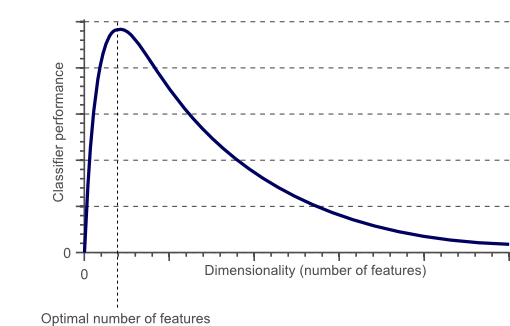
🔗Source



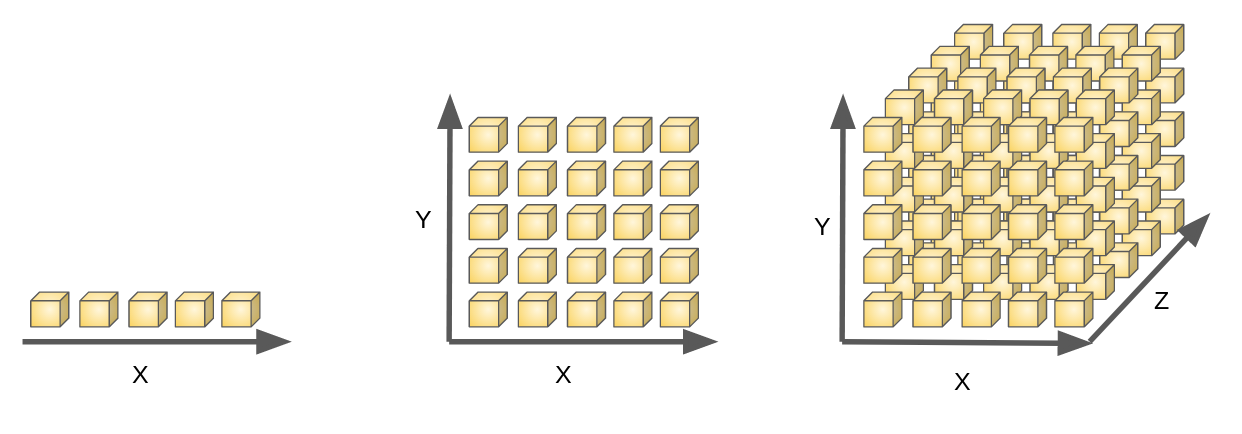
As the number of features or dimensions grows, the amount of data we need to generalize a model accurately grows exponentially 

🔗Source


🚨 Warning about OneHotEncoder: be careful about which features you encode!

- High variations within a categorical feature will generate more binary columns..
  - Consequently, you would need more data points
  - Spoiler : this is called "Curse of dimensionality"

# 🥨 Feature correlation
👩‍🏫 One of the feature selection techniques is to remove one of two features that are highly correlated to each other.

❗️ High correlation between feature A and feature B → redundant information.

🖥 Pearson Correlation

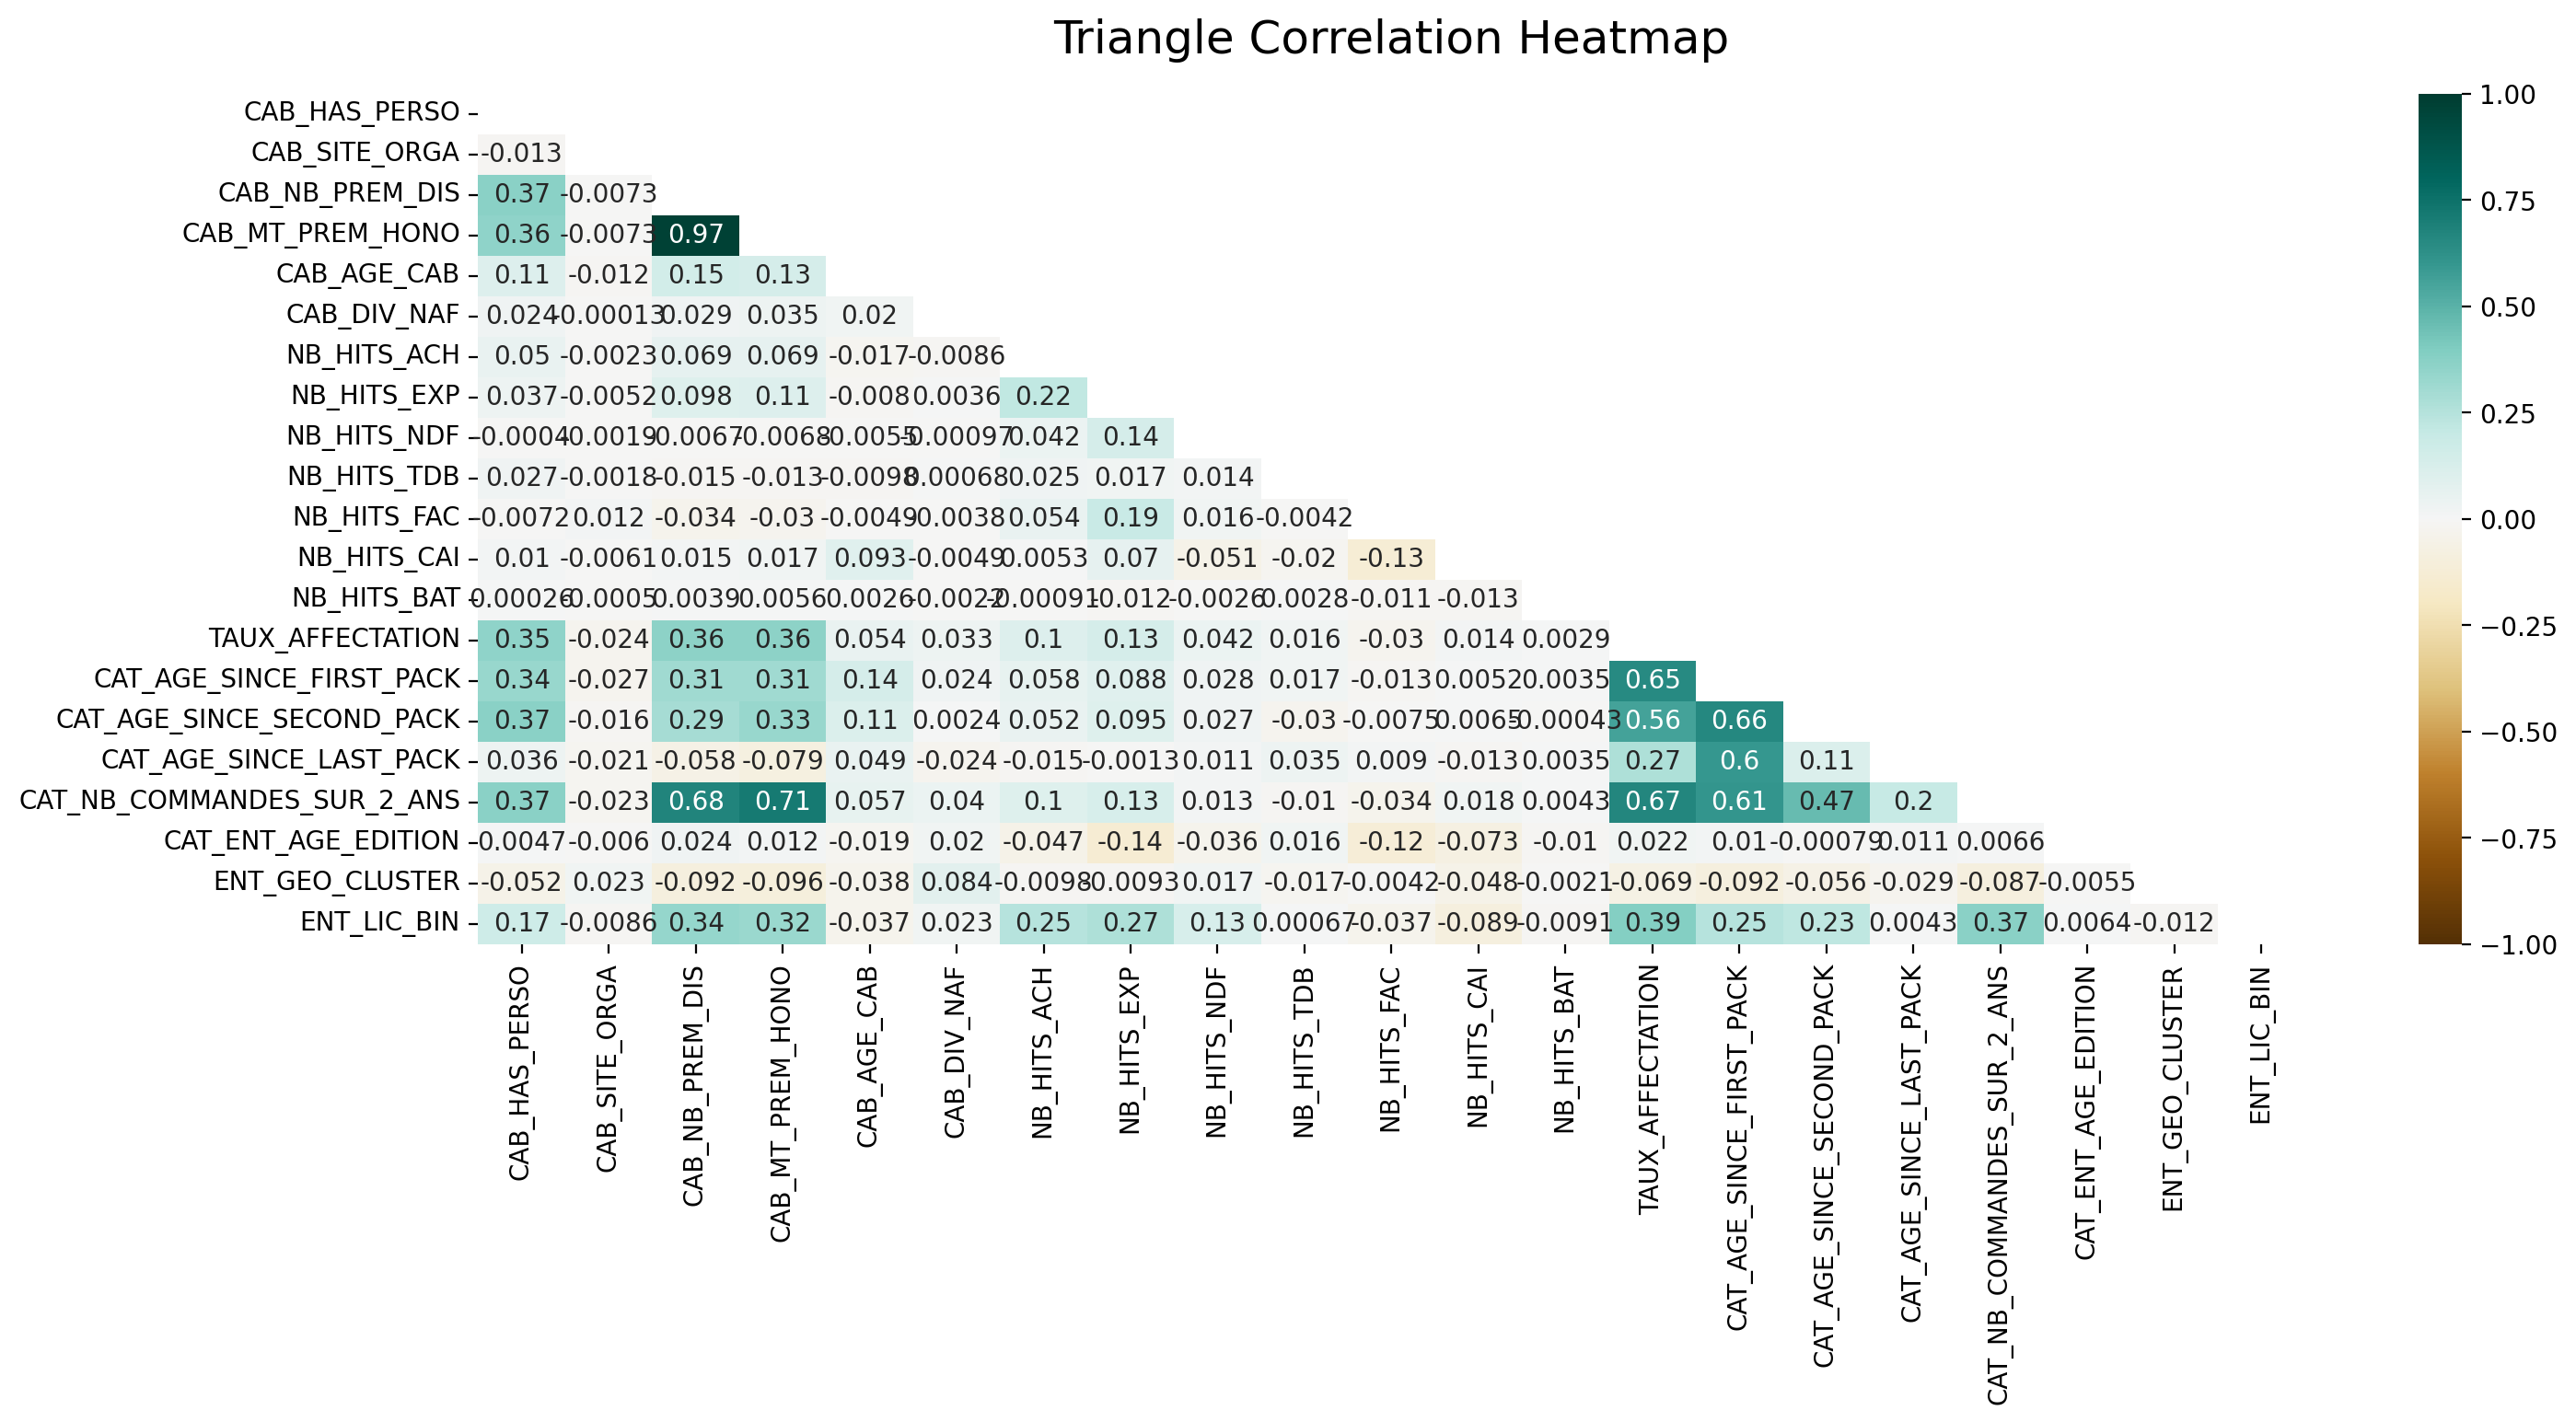

In [ ]:
corr = df.corr()

plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(corr, dtype=np.bool))
heatmap = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

In [ ]:
# Remove columns having higher VIF factor ot having high multicollinearity
Mult_Coll = ReduceVIF()
df_num = Mult_Coll.fit_transform(df.select_dtypes(include=np.number))
df_autres=df.select_dtypes(exclude=np.number)
df=pd.concat([df_num, df_autres], axis=1)
df.head(5)
# ReduceVIF fit and ReduceVIF transform are having high multicollinearity and dropped

ReduceVIF fit
ReduceVIF transform
Dropping CAB_MT_PREM_HONO with vif=27.16409169614045


CAB_NB_PREM_DIS  CAB_AGE_CAB  CAB_DIV_NAF  NB_HITS_ACH  NB_HITS_EXP  NB_HITS_NDF  NB_HITS_TDB  NB_HITS_FAC  NB_HITS_CAI  NB_HITS_BAT  TAUX_AFFECTATION  CAT_AGE_SINCE_FIRST_PACK  CAT_AGE_SINCE_SECOND_PACK  CAT_AGE_SINCE_LAST_PACK  CAT_NB_COMMANDES_SUR_2_ANS  CAT_ENT_AGE_EDITION  ENT_GEO_CLUSTER  ENT_LIC_BIN  ENT_LIC ENT_TYPE_CAP ENT_REG_FISC ENT_REG_IMP ENT_FORM_JUR  ENT_TYPE_TVA          ENT_ACT_TVA           ENT_REG_TVA ENT_TYPE_COMPTA ENT_TYPE_PACK_LIC ENT_SECT_ACT ENT_EFFECTIF ENT_CAT_ENT ENT_ETAT_ADM ENT_CAR_EMP ENT_SEC_NAF ENT_CAT_JUR_NIV1      CAB_TYPE_ACT  CAB_HAS_PERSO  CAB_SITE_ORGA CAB_EFFECTIF CAB_CAT_ENT CAB_ETAT_ADM CAB_CAR_EMP CAB_SEC_NAF CAB_CAT_JUR_NIV2
0             37.0        206.0         69.0          0.0          2.0          0.0          0.0          0.0          0.0          0.0          0.891892                       2.0                        2.0                      1.0                         0.0                  0.0              0.0          1.0  PREMIUM       SOCIAL          BNC          IR           EI  ENCAISSEMENT  PRESTATION_SERVICES    SIMPLIFIE_ANNUELLE      TRESORERIE           PACK_10     SERVICES           NN         PME            A           O           P              1.0  EXPERT_COMPTABLE          False          False           12         PME            A           O           M             54.0
1             24.0        386.0         69.0          0.0          0.0          0.0          0.0         16.0          0.0          0.0          0.500000                       3.0                        3.0                      0.0                         0.0                  0.0             -1.0          0.0     FREE       SOCIAL          BIC          IR           EI  ENCAISSEMENT  PRESTATION_SERVICES  NORMAL_TRIMESTRIELLE      ENGAGEMENT           PACK_10     SERVICES           NN         PME            A           N           L              1.0  EXPERT_COMPTABLE          False          False           NN         ETI            C           N           M             55.0
2             16.0        129.0         69.0          0.0          6.0          0.0          0.0         92.0          0.0          0.0          0.812500                       3.0                        3.0                      1.0                         0.0                  2.0              1.0          0.0     FREE       SOCIAL          BIC          IS           SA  ENCAISSEMENT  PRESTATION_SERVICES      NORMAL_MENSUELLE      ENGAGEMENT           PACK_10        AUTRE           11         PME            C           O           J              5.0  EXPERT_COMPTABLE           True          False           NN         PME            A           N           M             57.0
3              6.0        554.0         69.0          0.0          2.0          0.0          0.0        259.0          0.0          0.0          0.333333                       3.0                       -1.0                      3.0                         0.0                  1.0              0.0          0.0     FREE       SOCIAL          BIC          IR         CUMA  ENCAISSEMENT  PRESTATION_SERVICES    SIMPLIFIE_ANNUELLE      ENGAGEMENT           PACK_10     SERVICES           01         PME            A           N           N              6.0  EXPERT_COMPTABLE          False          False           32         ETI            A           O           M             92.0
4              0.0        359.0         69.0          0.0          4.0          0.0          0.0       1474.0          0.0          0.0          0.000000                      -1.0                       -1.0                     -1.0                        -1.0                  0.0              2.0          0.0     FREE       SOCIAL          BIC          IS         SARL  ENCAISSEMENT  PRESTATION_SERVICES      NORMAL_MENSUELLE      ENGAGEMENT           PACK_10     SERVICES           02         PME            A           O           M              5.0  EXPERT_COMPTABLE          False          Fa

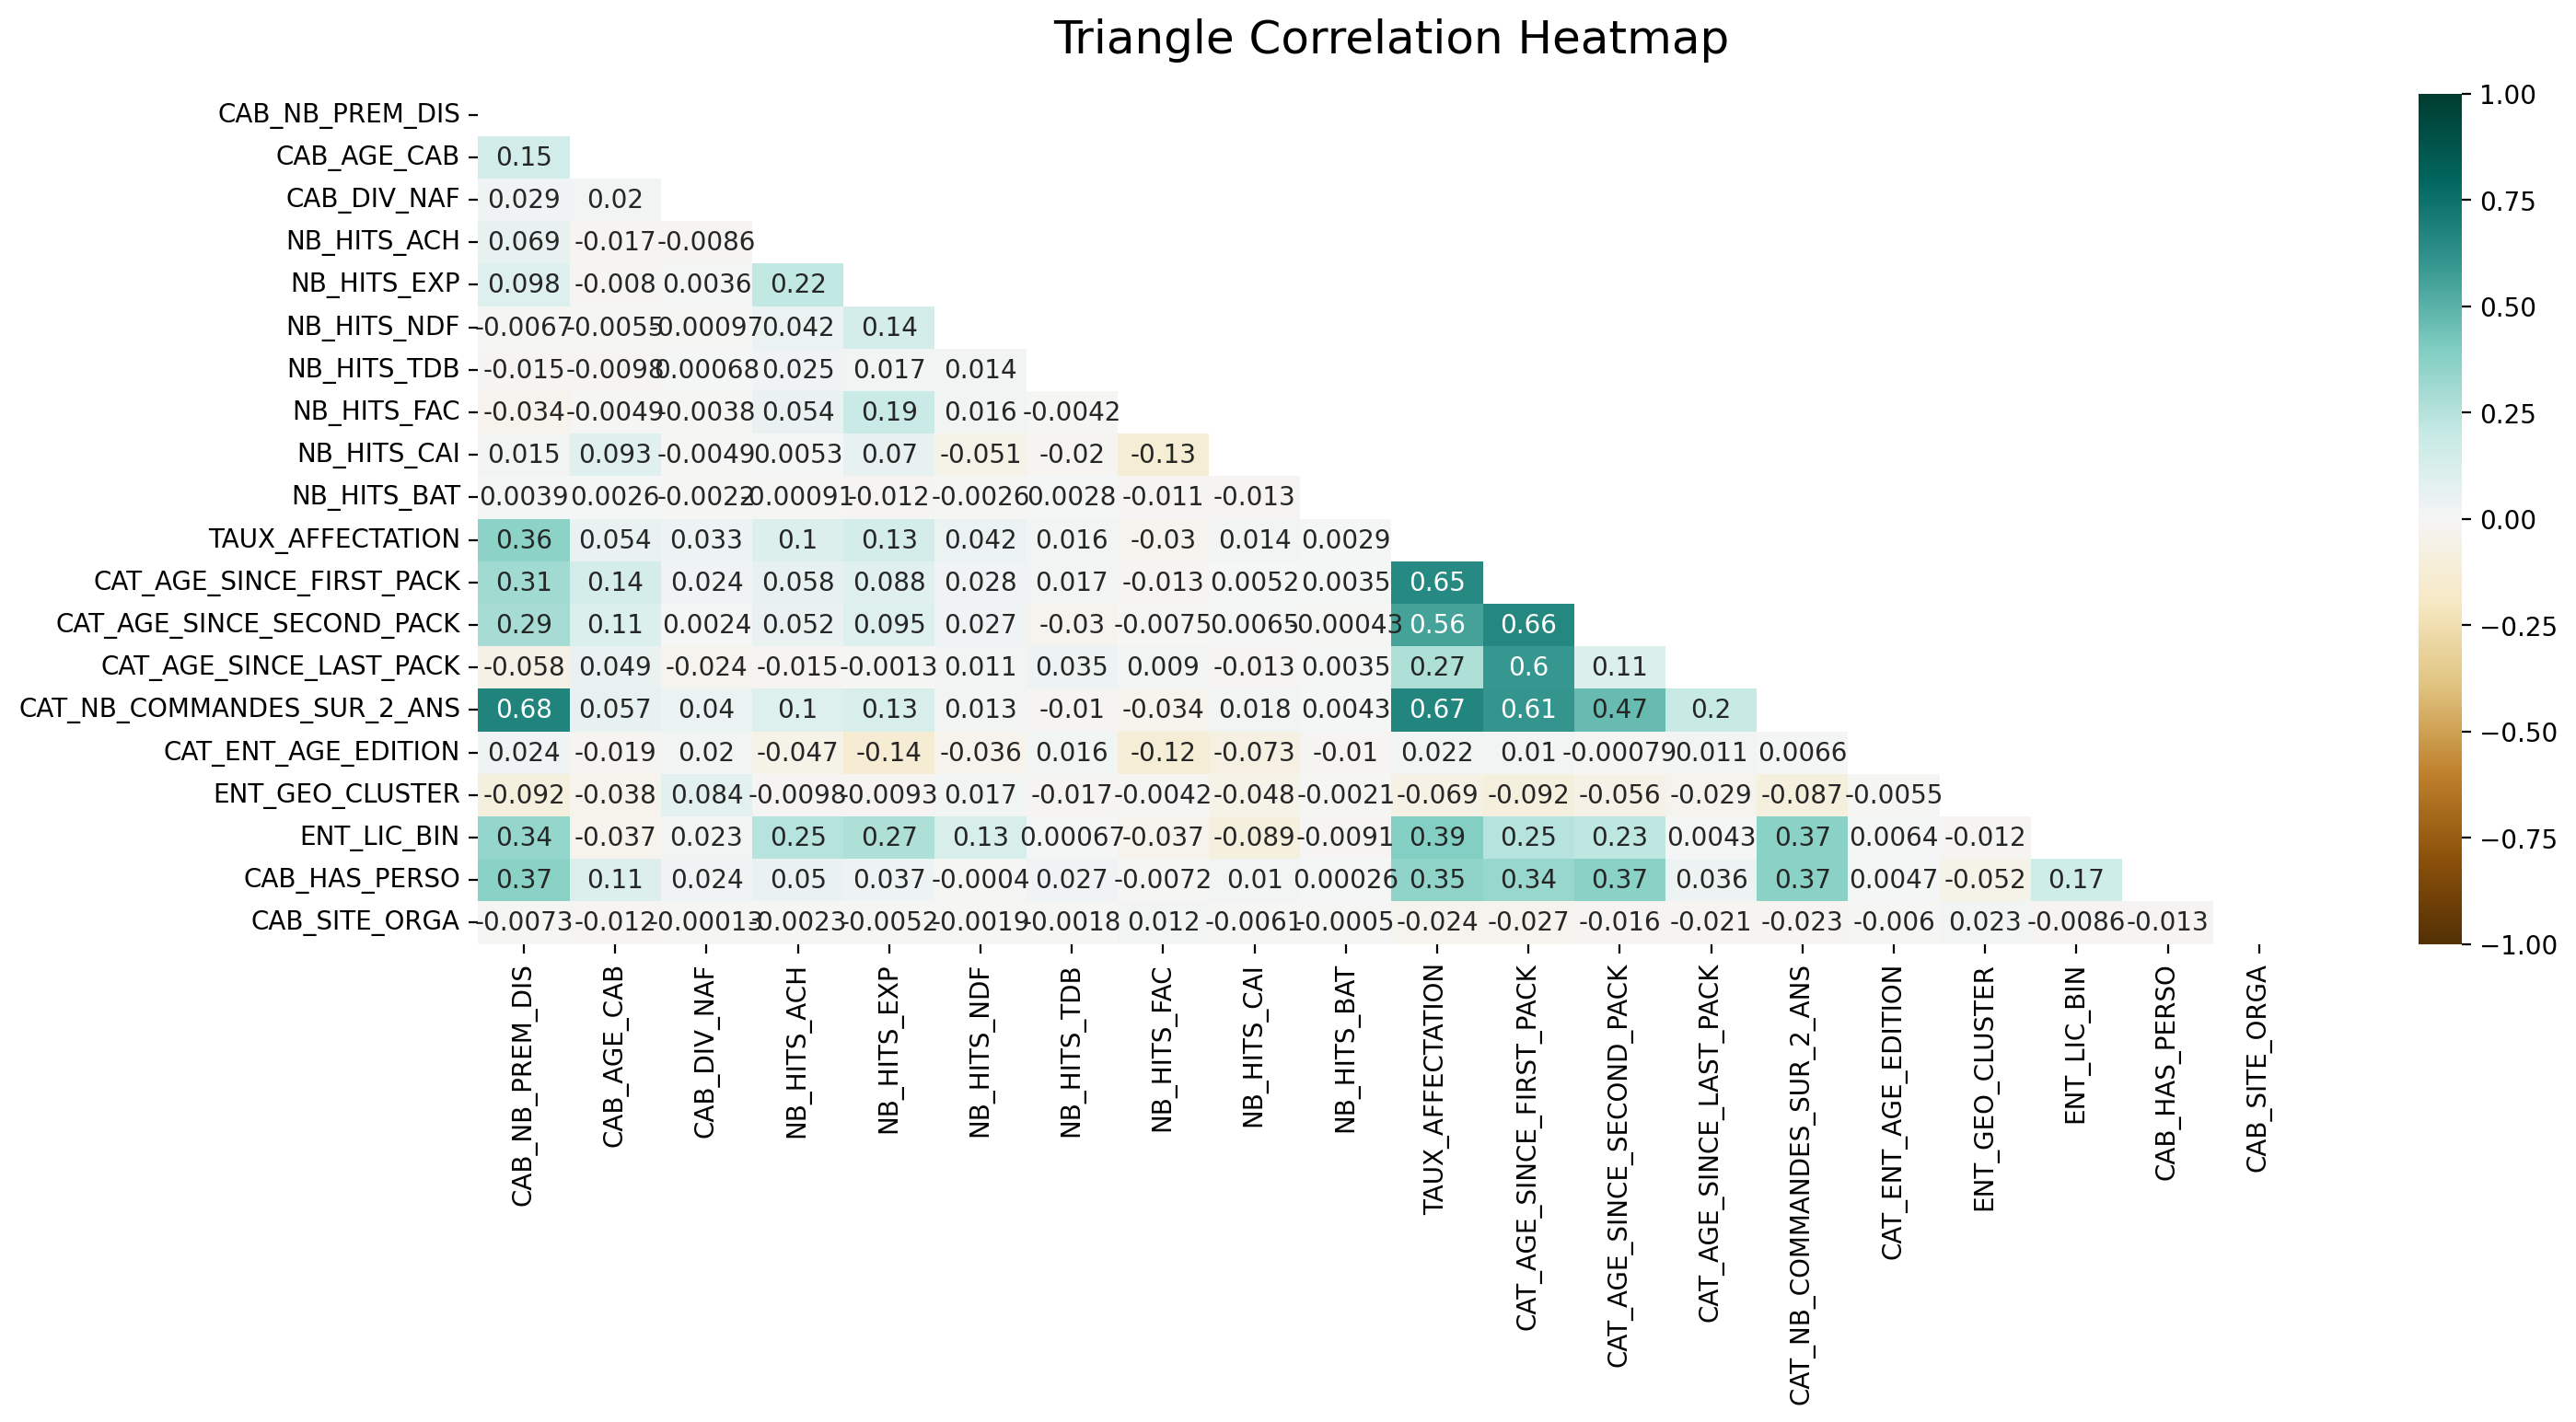

In [ ]:
corr = df.corr()

plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(corr, dtype=np.bool))
heatmap = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

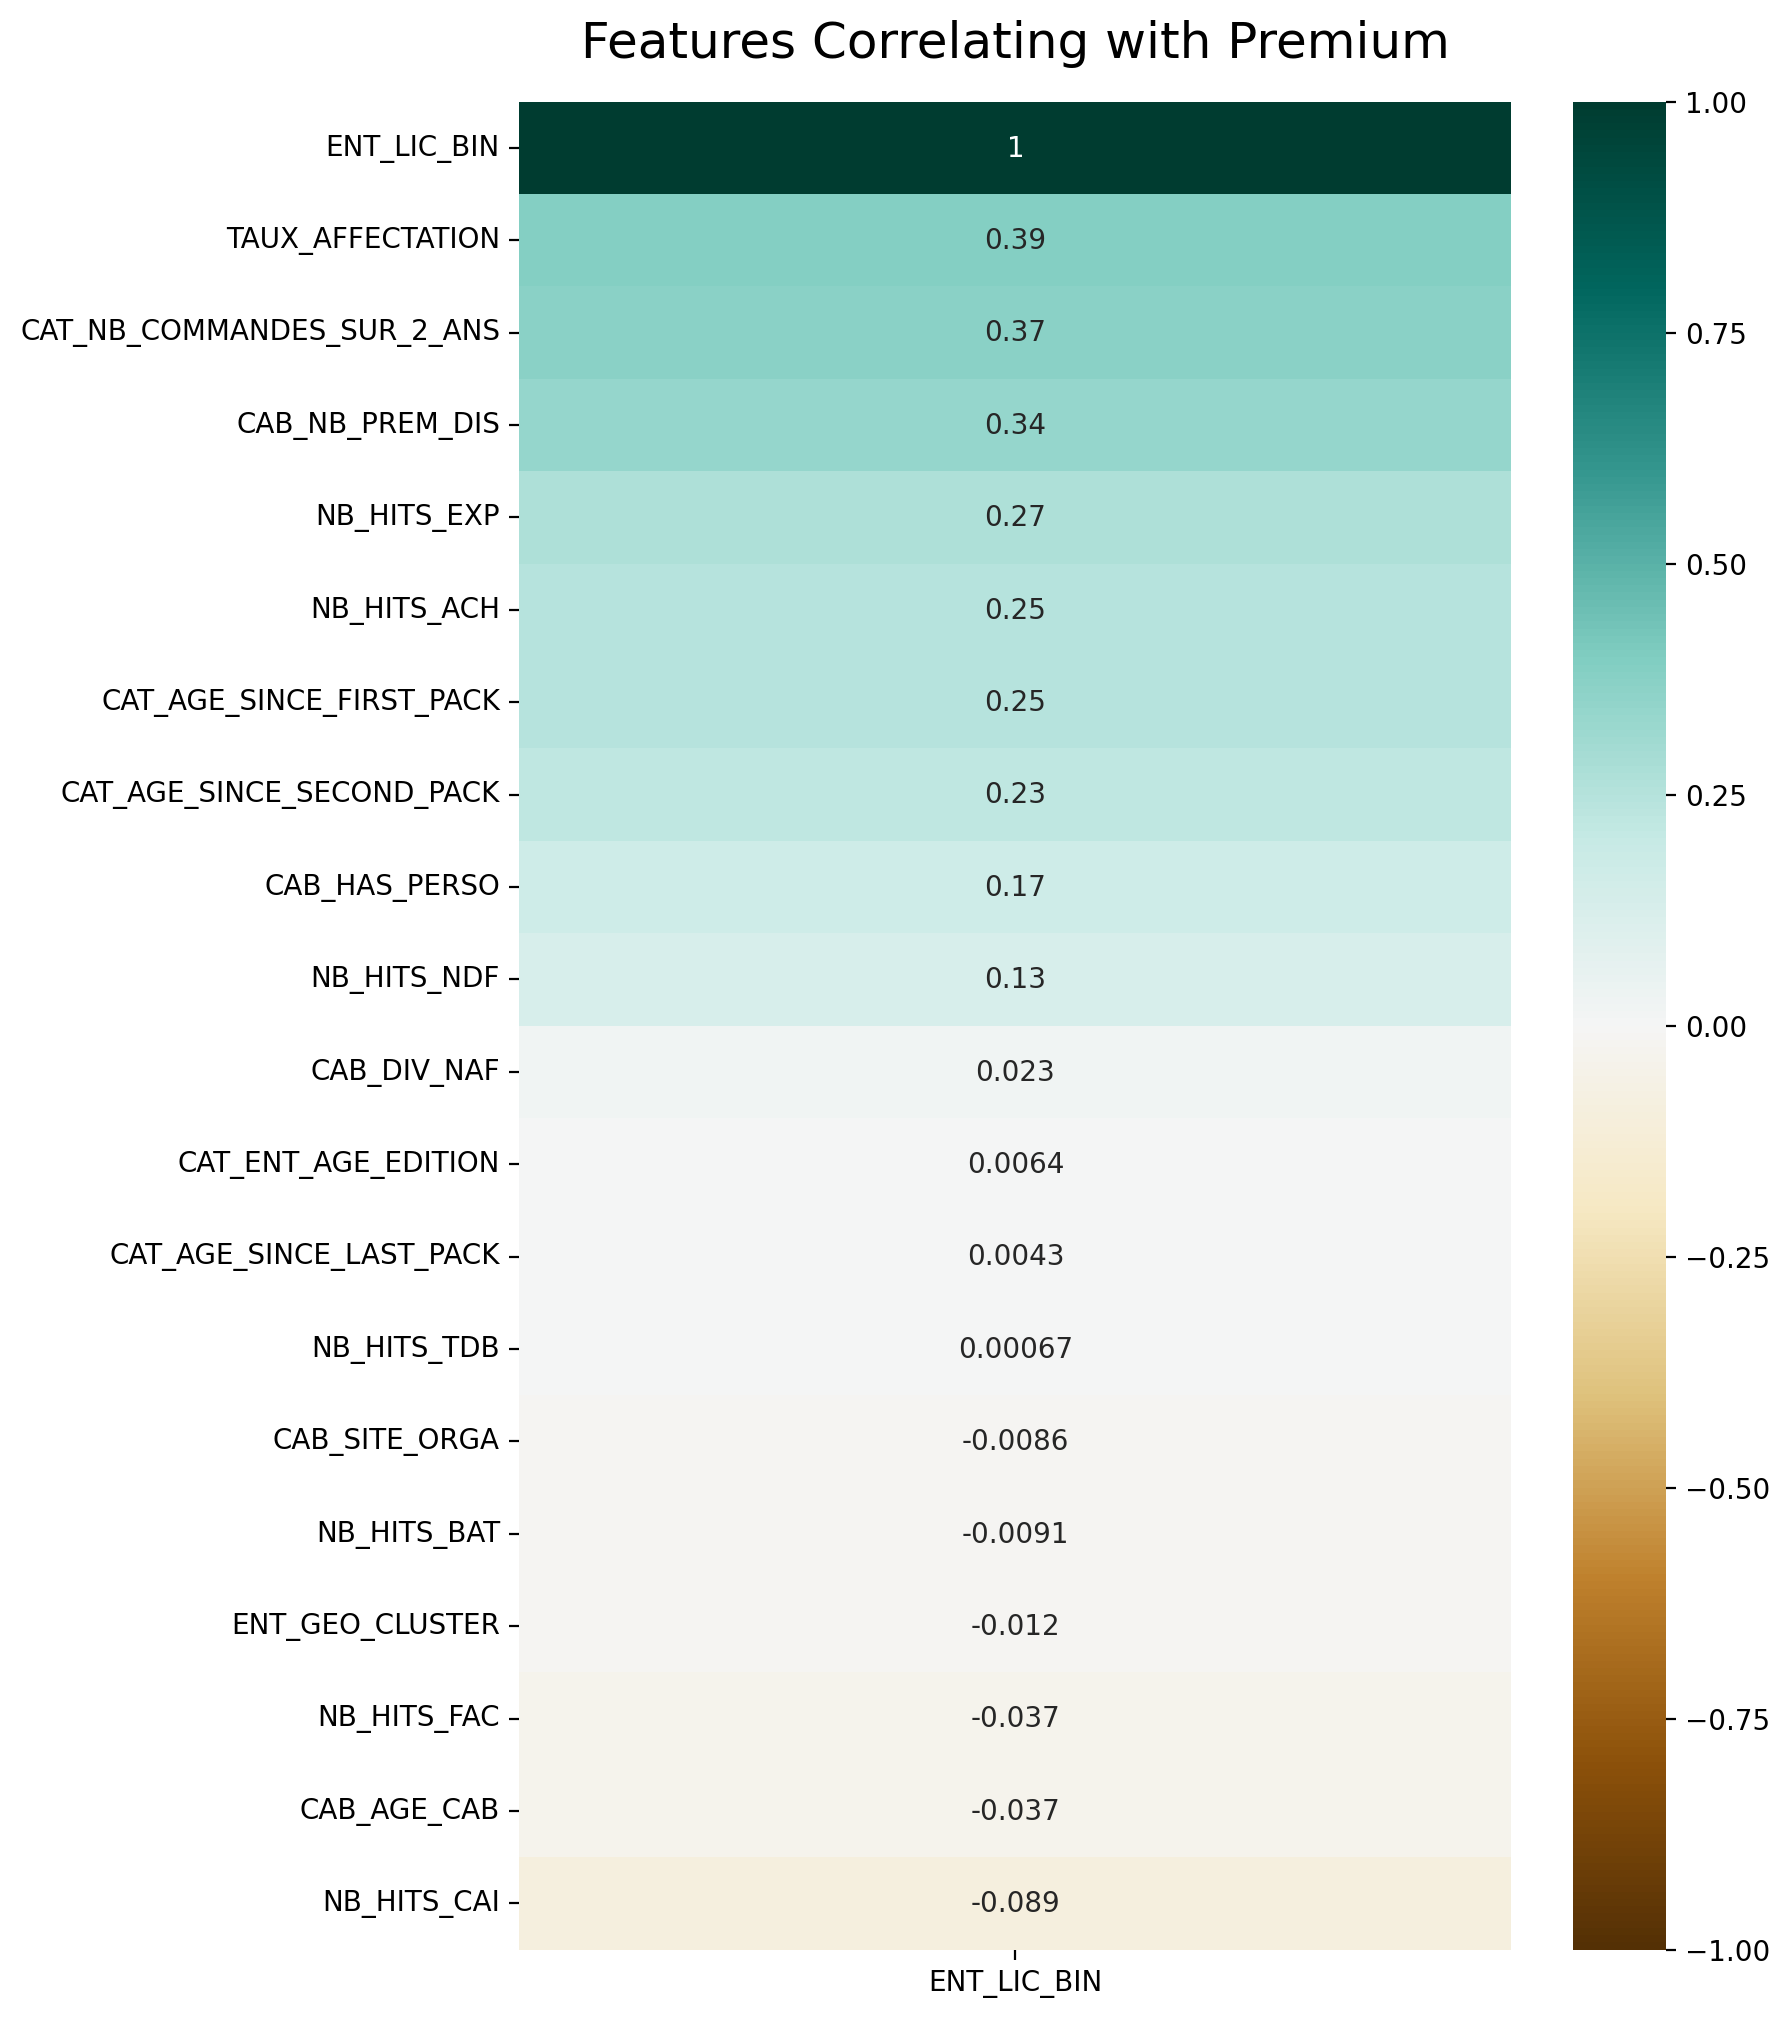

In [ ]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(corr[['ENT_LIC_BIN']].sort_values(by='ENT_LIC_BIN', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Premium', fontdict={'fontsize':18}, pad=16);

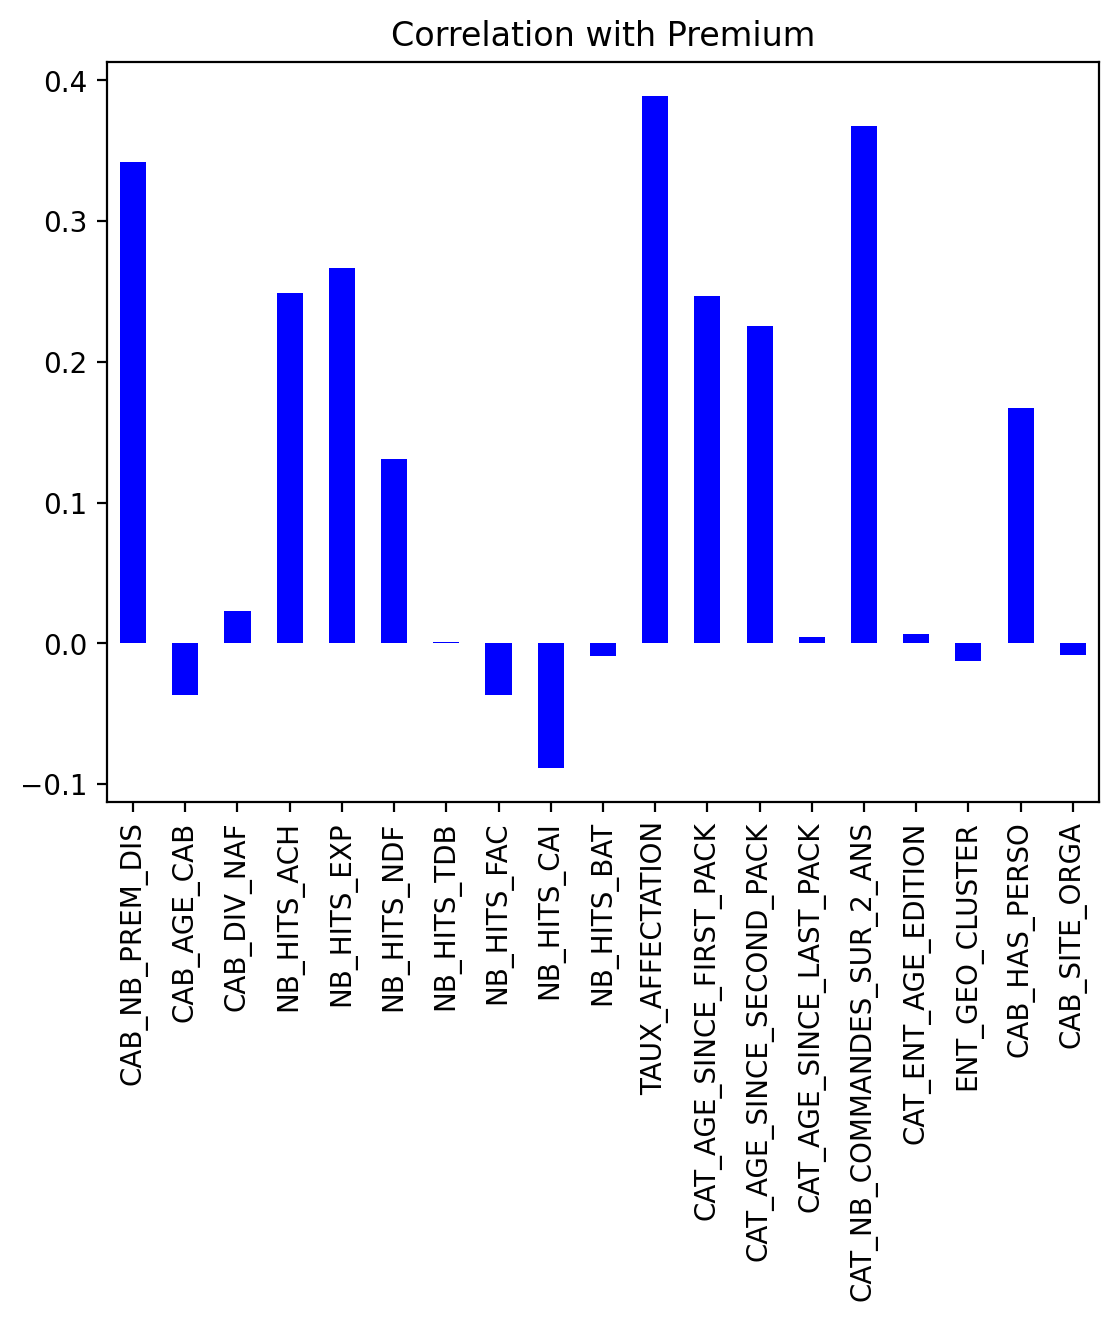

In [ ]:
l = list(corr)
l.remove("ENT_LIC_BIN")
corr['ENT_LIC_BIN'][l].plot.bar(color = 'b');
plt.title('Correlation with Premium');

Let's turn the correlation matrix into a DataFrame.

In [ ]:
# Converting the correlation matrix into a DataFrame
corr_df = corr.stack().reset_index()

# Renaming the columns
corr_df.columns = ['feature_1','feature_2', 'correlation']

# Remove "self correlations"
no_self_correlation = (corr_df['feature_1'] != corr_df['feature_2'])
corr_df = corr_df[no_self_correlation]

Let's see which pairs of features are the most correlated (both positively and negatively)

In [ ]:
# Computing the absolute correlation
corr_df['absolute_correlation'] = np.abs(corr_df['correlation'])

# Showing the top 5 most correlated pairs of feature
corr_df.sort_values(by="absolute_correlation", ascending=False).head(5*3)

feature_1                   feature_2  correlation  absolute_correlation
280  CAT_NB_COMMANDES_SUR_2_ANS             CAB_NB_PREM_DIS     0.675917              0.675917
14              CAB_NB_PREM_DIS  CAT_NB_COMMANDES_SUR_2_ANS     0.675917              0.675917
290  CAT_NB_COMMANDES_SUR_2_ANS            TAUX_AFFECTATION     0.671586              0.671586
214            TAUX_AFFECTATION  CAT_NB_COMMANDES_SUR_2_ANS     0.671586              0.671586
251   CAT_AGE_SINCE_SECOND_PACK    CAT_AGE_SINCE_FIRST_PACK     0.663696              0.663696
232    CAT_AGE_SINCE_FIRST_PACK   CAT_AGE_SINCE_SECOND_PACK     0.663696              0.663696
211            TAUX_AFFECTATION    CAT_AGE_SINCE_FIRST_PACK     0.649446              0.649446
230    CAT_AGE_SINCE_FIRST_PACK            TAUX_AFFECTATION     0.649446              0.649446
291  CAT_NB_COMMANDES_SUR_2_ANS    CAT_AGE_SINCE_FIRST_PACK     0.607782              0.607782
234    CAT_AGE_SINCE_FIRST_PACK  CAT_NB_COMMANDES_SUR_2_ANS     0.607782              0.607782
233    CAT_AGE_SINCE_FIRST_PACK     CAT_AGE_SINCE_LAST_PACK     0.596485              0.596485
271     CAT_AGE_SINCE_LAST_PACK    CAT_AGE_SINCE_FIRST_PACK     0.596485              0.596485
250   CAT_AGE_SINCE_SECOND_PACK            TAUX_AFFECTATION     0.556896              0.556896
212            TAUX_AFFECTATION   CAT_AGE_SINCE_SECOND_PACK     0.556896              0.556896
254   CAT_AGE_SINCE_SECOND_PACK  CAT_NB_COMMANDES_SUR_2_ANS     0.467073              0.467073

💡 Hints:

- Remove as many of the "redundant" columns as you want, starting from those with the highest correlation

- Keep doing it until your model's performance starts to drop significantly. At this point, you may have dropped too many features.


❓ Which pair of columns has the highest correlation ❓
The 🔢 feature Pesos is perfectly correlated to the 🎯 target SalePrice.
👀 What are we observing?

# ⚖️ Dataset balancing
## Why balancing?¶
- 🤝 Machine Learning algorithms learn by example
- 😓 If a class is underrepresented enough, the model will tend to predict the under-represented class poorly
⚖️ A 70/30 ratio (class A / class B) split for binary classification can be considered imbalanced

## Balancing strategies¶
- Oversampling of minority class
  - Alternatively, Computation of new instances for the minority class
- Undersampling of majority class

## Oversampling or Undersampling
### Oversampling = duplicating instances of the minority class
### Undersampling = sampling down the majority class.

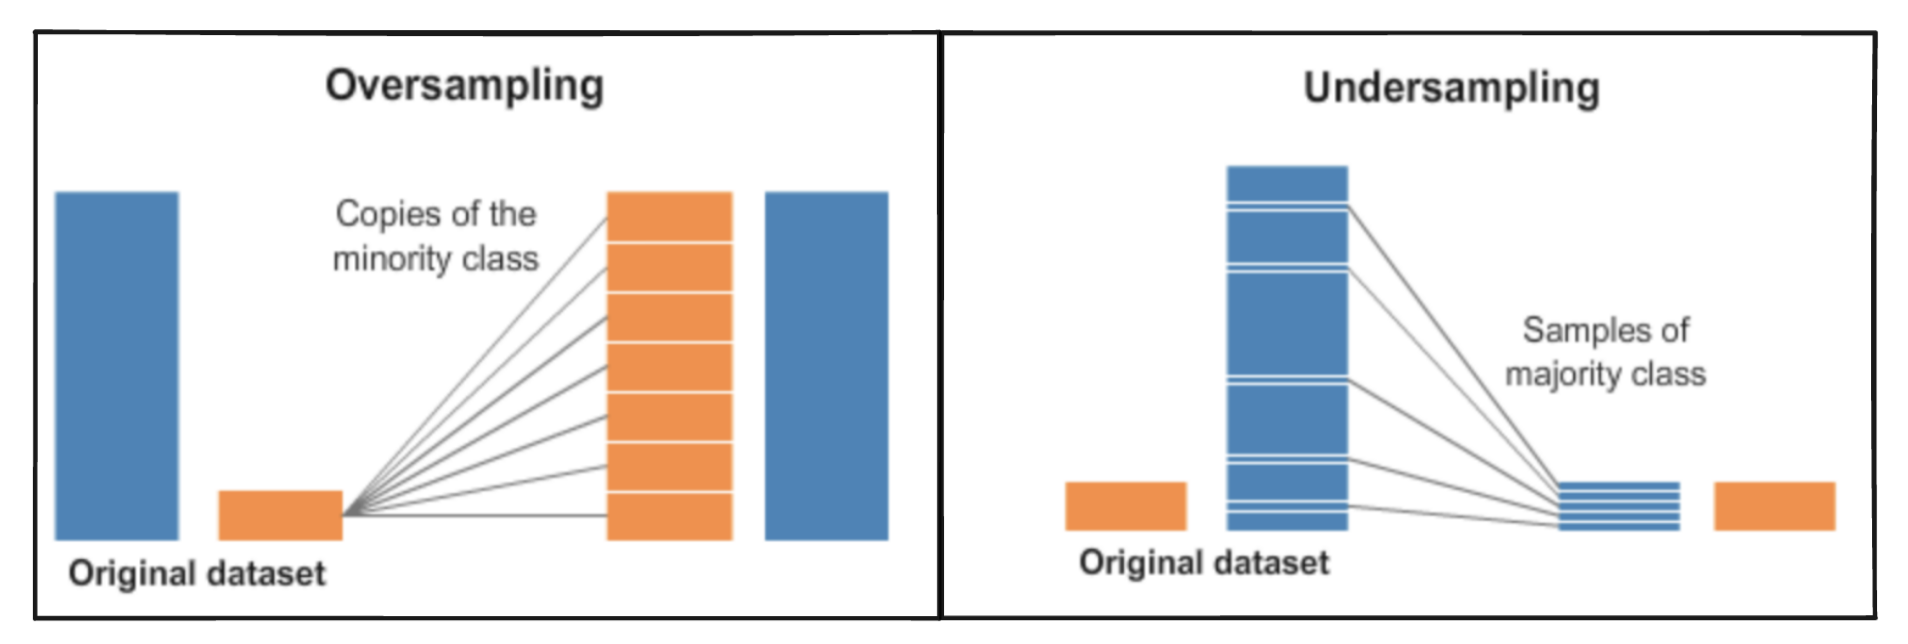

❗️ Warning about the oversampling method ❗️

1. Train-test split your dataset before oversampling
2. versample only in the train set  
3.   The model needs to learn about the minority class.
Evaluate in the test set without oversampling We want the model to be evaluated in real conditions

In [ ]:
print("Pourcentage PREMIUM:\t%.1f%%" % ((df['ENT_LIC_BIN'].sum() / df['ENT_LIC_BIN'].shape[0])*100))

Pourcentage PREMIUM:	20.4%


In [ ]:

df.drop(columns=[
    'CAB_NB_PREM_DIS', 
    'CAB_HAS_PERSO', 
    'CAB_SITE_ORGA', 
    'ENT_LIC_BIN', 
    'CAT_AGE_SINCE_FIRST_PACK', 
    'CAT_AGE_SINCE_SECOND_PACK', 
    'CAT_NB_COMMANDES_SUR_2_ANS', 
    'CAT_ENT_AGE_EDITION',
     'TAUX_AFFECTATION', 
     'CAB_ETAT_ADM',
     'ENT_ETAT_ADM', 
     'CAB_TYPE_ACT', 
     'ENT_TYPE_CAP',
     'CAB_DIV_NAF',
     'ENT_CAT_ENT',
     'NB_HITS_BAT',
     'ENT_TYPE_PACK_LIC',
     'NB_HITS_TDB',
     'CAB_SEC_NAF',
     'ENT_REG_IMP'
     ], inplace=True)
#df.drop(columns=['CAB_NB_PREM_DIS', 'CAB_HAS_PERSO', 'CAB_SITE_ORGA', 'ENT_LIC_BIN'], inplace=True)

df.head(5)

CAB_AGE_CAB  NB_HITS_ACH  NB_HITS_EXP  NB_HITS_NDF  NB_HITS_FAC  NB_HITS_CAI  CAT_AGE_SINCE_LAST_PACK  ENT_GEO_CLUSTER  ENT_LIC ENT_REG_FISC ENT_FORM_JUR  ENT_TYPE_TVA          ENT_ACT_TVA           ENT_REG_TVA ENT_TYPE_COMPTA ENT_SECT_ACT ENT_EFFECTIF ENT_CAR_EMP ENT_SEC_NAF ENT_CAT_JUR_NIV1 CAB_EFFECTIF CAB_CAT_ENT CAB_CAR_EMP CAB_CAT_JUR_NIV2
0        206.0          0.0          2.0          0.0          0.0          0.0                      1.0              0.0  PREMIUM          BNC           EI  ENCAISSEMENT  PRESTATION_SERVICES    SIMPLIFIE_ANNUELLE      TRESORERIE     SERVICES           NN           O           P              1.0           12         PME           O             54.0
1        386.0          0.0          0.0          0.0         16.0          0.0                      0.0             -1.0     FREE          BIC           EI  ENCAISSEMENT  PRESTATION_SERVICES  NORMAL_TRIMESTRIELLE      ENGAGEMENT     SERVICES           NN           N           L              1.0           NN         ETI           N             55.0
2        129.0          0.0          6.0          0.0         92.0          0.0                      1.0              1.0     FREE          BIC           SA  ENCAISSEMENT  PRESTATION_SERVICES      NORMAL_MENSUELLE      ENGAGEMENT        AUTRE           11           O           J              5.0           NN         PME           N             57.0
3        554.0          0.0          2.0          0.0        259.0          0.0                      3.0              0.0     FREE          BIC         CUMA  ENCAISSEMENT  PRESTATION_SERVICES    SIMPLIFIE_ANNUELLE      ENGAGEMENT     SERVICES           01           N           N              6.0           32         ETI           O             92.0
4        359.0          0.0          4.0          0.0       1474.0          0.0                     -1.0              2.0     FREE          BIC         SARL  ENCAISSEMENT  PRESTATION_SERVICES      NORMAL_MENSUELLE      ENGAGEMENT     SERVICES           02           O           M              5.0           02         PME           O             54.0

Define a seed for reproducibility:

In [ ]:
rand = 42
os.environ['PYTHONHASHSEED']=str(rand)
np.random.seed(rand)

In [ ]:
m = cb.CatBoostClassifier(eval_metric='Precision', depth=10, auto_class_weights='Balanced', task_type="CPU", use_best_model=True, l2_leaf_reg= 3, n_estimators=200, learning_rate=0.1, random_state=rand, verbose=0)
df=df.convert_dtypes()
#df.drop(columns=['CAB_NB_PREM_DIS', 'CAB_HAS_PERSO', 'CAB_SITE_ORGA', 'ENT_LIC_BIN', 'CAT_AGE_SINCE_FIRST_PACK', 'CAT_AGE_SINCE_SECOND_PACK', 'CAT_NB_COMMANDES_SUR_2_ANS', 'CAT_ENT_AGE_EDITION', 'TAUX_AFFECTATION'], inplace=True)

y=df['ENT_LIC']
X=df.drop(columns=['ENT_LIC', 'CAT_AGE_SINCE_LAST_PACK'])

# Encoding the target
#target_encoder = LabelEncoder().fit(df['ENT_LIC']) 
#y = target_encoder.transform(df['ENT_LIC'])
y=df['ENT_LIC'].replace({'FREE': '0', 'PREMIUM': '1'}).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=rand)
cat_features = X.columns[np.where(X.dtypes != float)[0]].values.tolist()
X[cat_features] = X[cat_features].astype(str)

m.fit(X_train, y_train, cat_features=cat_features,
       eval_set=(X_test, y_test), plot=True)



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

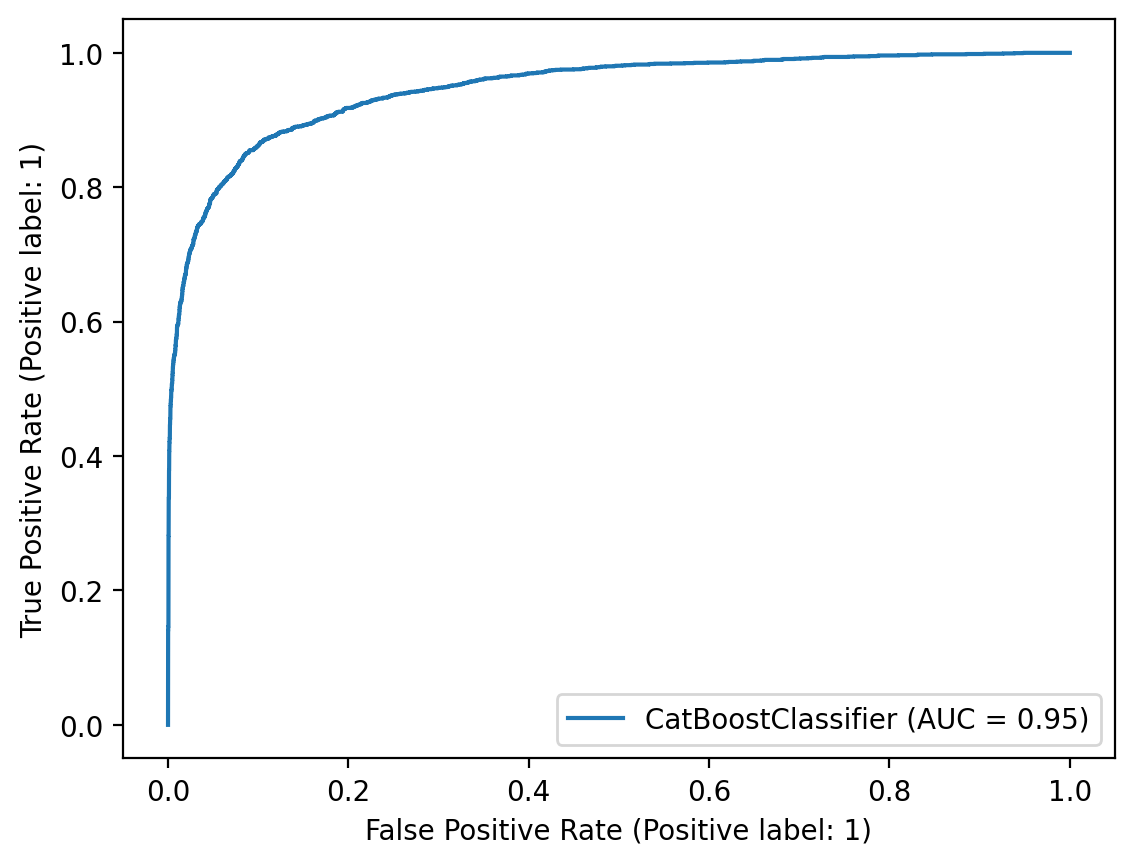

In [ ]:
model_disp = RocCurveDisplay.from_estimator(m, X_test, y_test)
plt.show()

In [ ]:
y_train_pred = m.predict(X_train)
y_test_prob = m.predict_proba(X_test)[:,1]
y_test_pred = np.where(y_test_prob > 0.5, 1, 0)
result=dict(
    pred_test=y_test_pred,
    prob_test=y_test_prob,
    acc_train=metrics.accuracy_score(y_train.values, y_train_pred),
    acc_test=metrics.accuracy_score(y_test.values, y_test_pred),
    precision=metrics.precision_score(y_test.values, y_test_pred),
    recall=metrics.recall_score(y_test.values, y_test_pred),
    f1=metrics.f1_score(y_test.values, y_test_pred),
    roc_auc=metrics.roc_auc_score(y_test.values, y_test_prob),
    mcc=metrics.matthews_corrcoef(y_test.values, y_test_pred)
)

In [ ]:
def set_header_font():
    return [dict(selector="th", props=[("font-size", "14pt")])]

class_metrics_df = pd.DataFrame([result]).drop(['pred_test','prob_test'], axis=1)
class_metrics_df = class_metrics_df*100
class_metrics_df.sort_values(by='f1', ascending=False).style.\
    format(dict(zip(class_metrics_df.columns, ['{:.1f}']*7))).\
    set_properties(**{'font-size': '13pt'}).set_table_styles(set_header_font()).\
    background_gradient(cmap='plasma', low=0.3, high=0.1, subset=['acc_train', 'acc_test']).\
    background_gradient(cmap='viridis', low=0.3, high=0.1, subset=['precision','recall',\
                                                                 'f1', 'mcc']).\
    highlight_quantile(q_left=0, q_right=0.6, props='color:black; background-color:inherit').\
    highlight_max(props='font-weight:bold;')

In [ ]:
predict_df = pd.DataFrame({
                          'y_true': y_test.tolist(),
                          'y_pred': result['pred_test'],
                          'y_prob': result['prob_test']}, index=X_test.index)

confusion_matrix = pd.crosstab(index= predict_df['y_pred'],
                               columns = predict_df['y_true'])
confusion_matrix

y_true     0     1
y_pred            
0       8221   374
1        705  1919

Global Explanations with SHAP

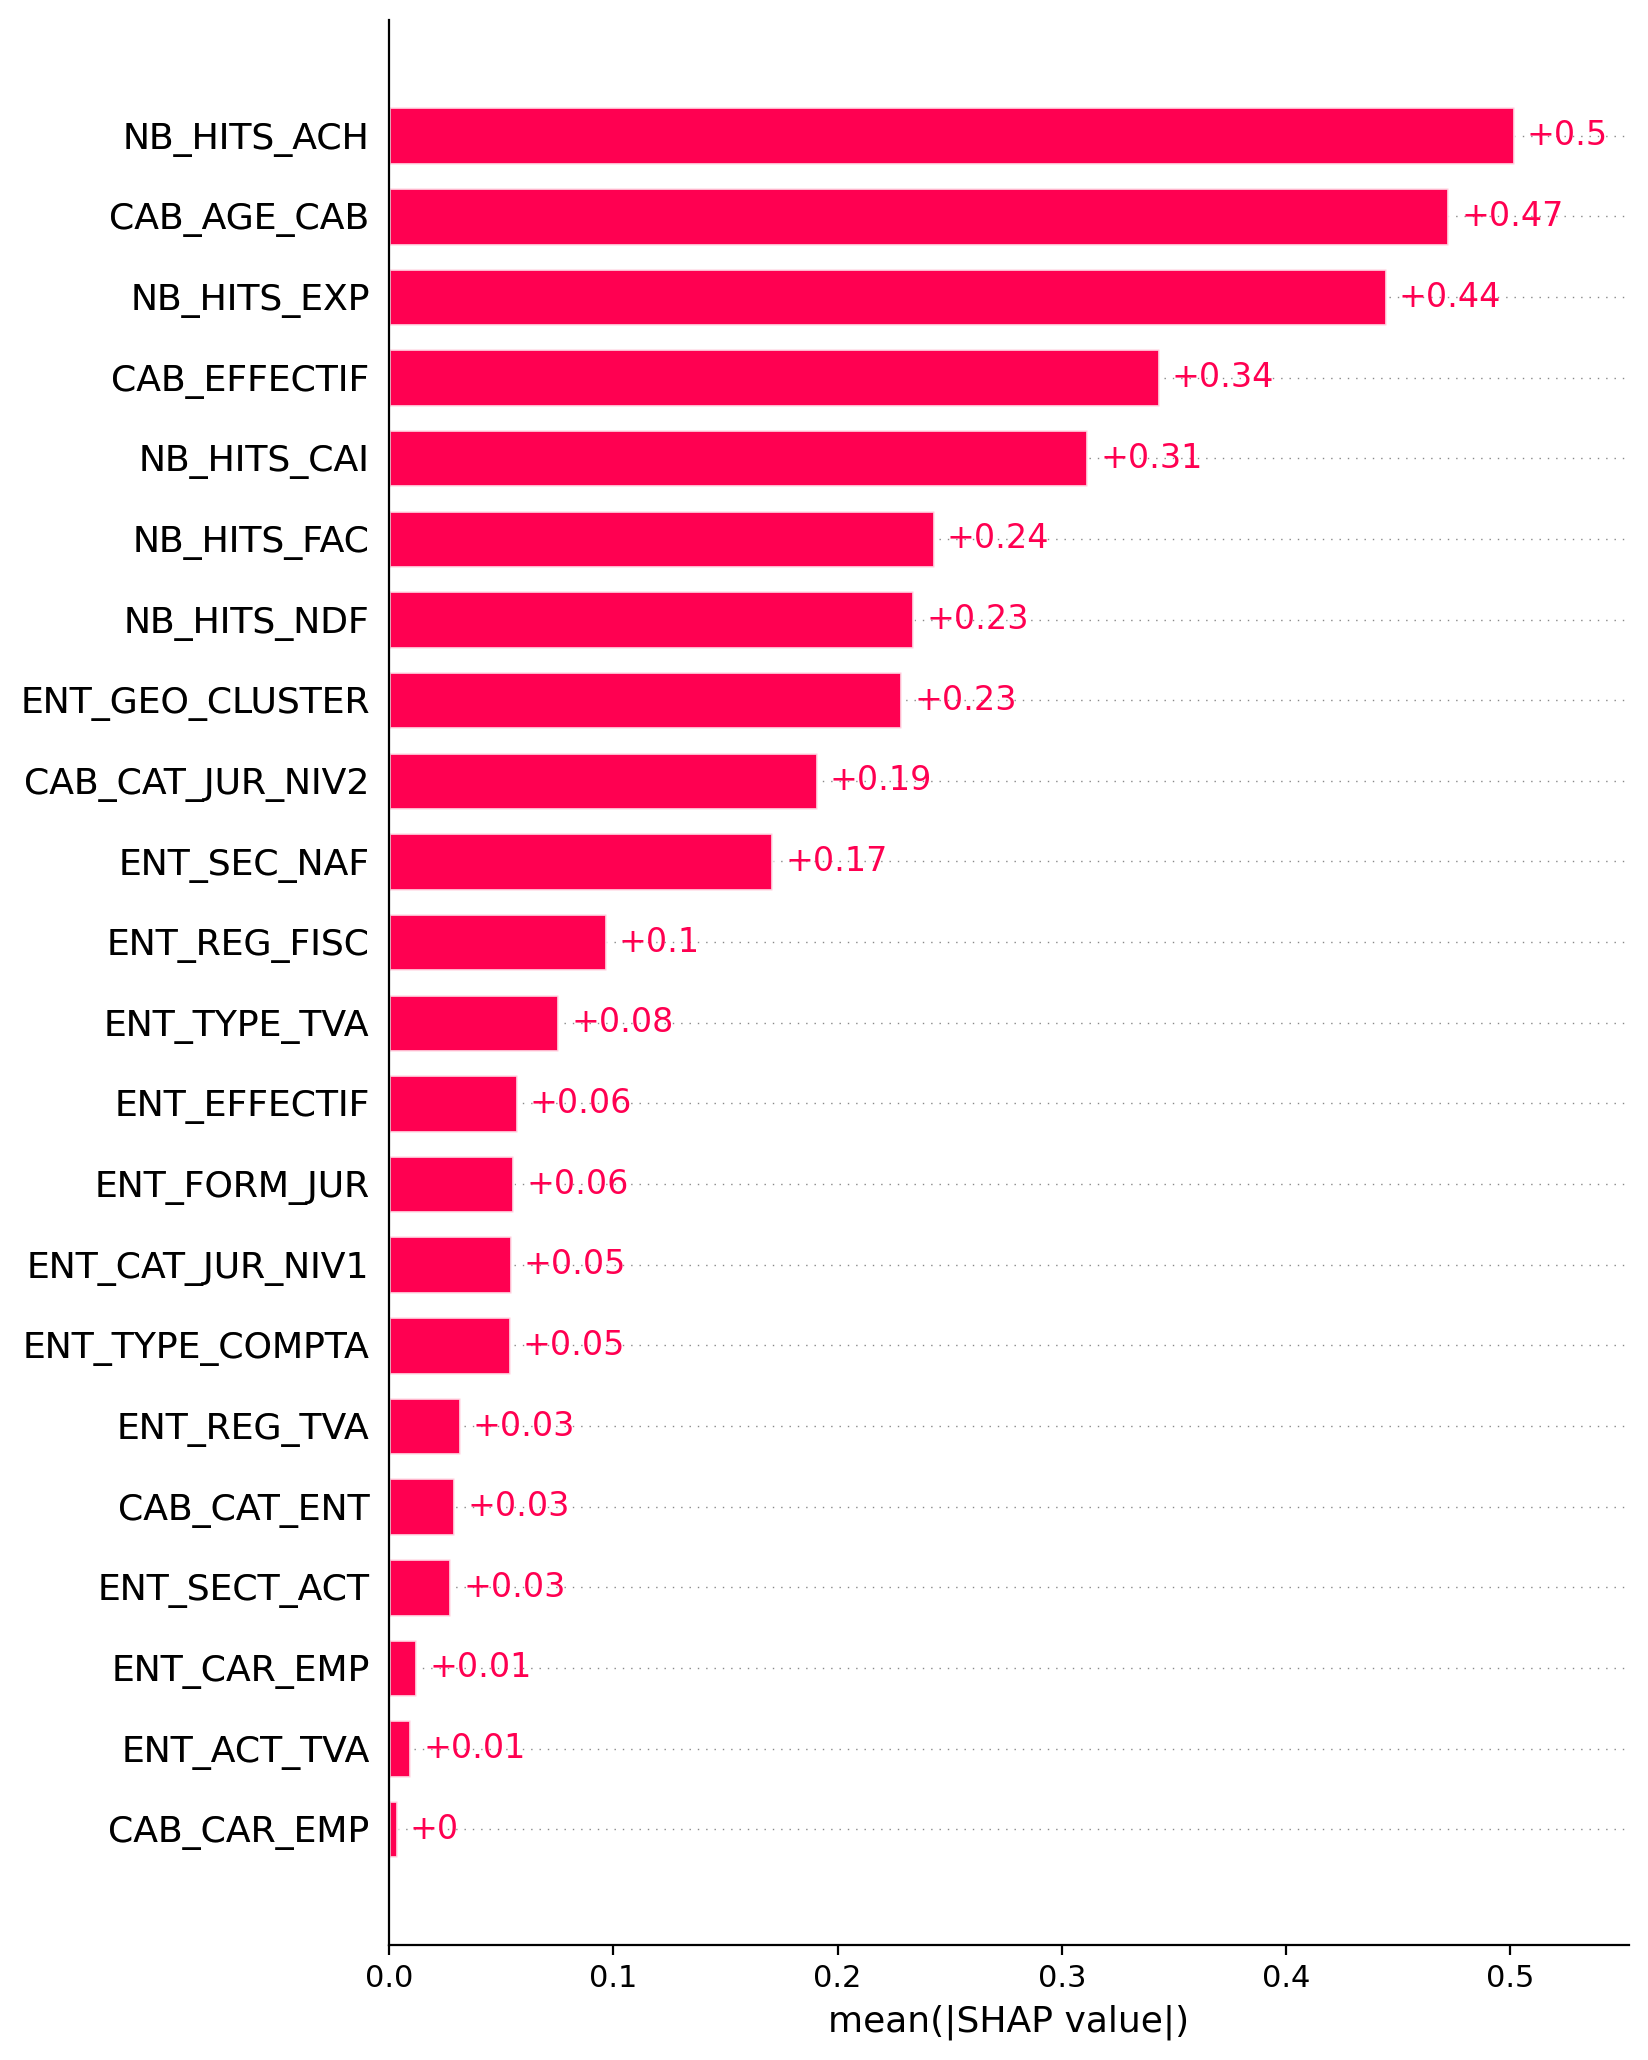

In [ ]:
#load JS vis in the notebook
shap.initjs() 

#set the tree explainer as the model of the pipeline
explainer = shap.TreeExplainer(m)

#get Shap values from preprocessed data
cb_shap = explainer(X_test)

plt.figure(figsize=(12, 12), dpi=100)
shap.plots.bar(cb_shap, max_display=50, show=False)
plt.show()

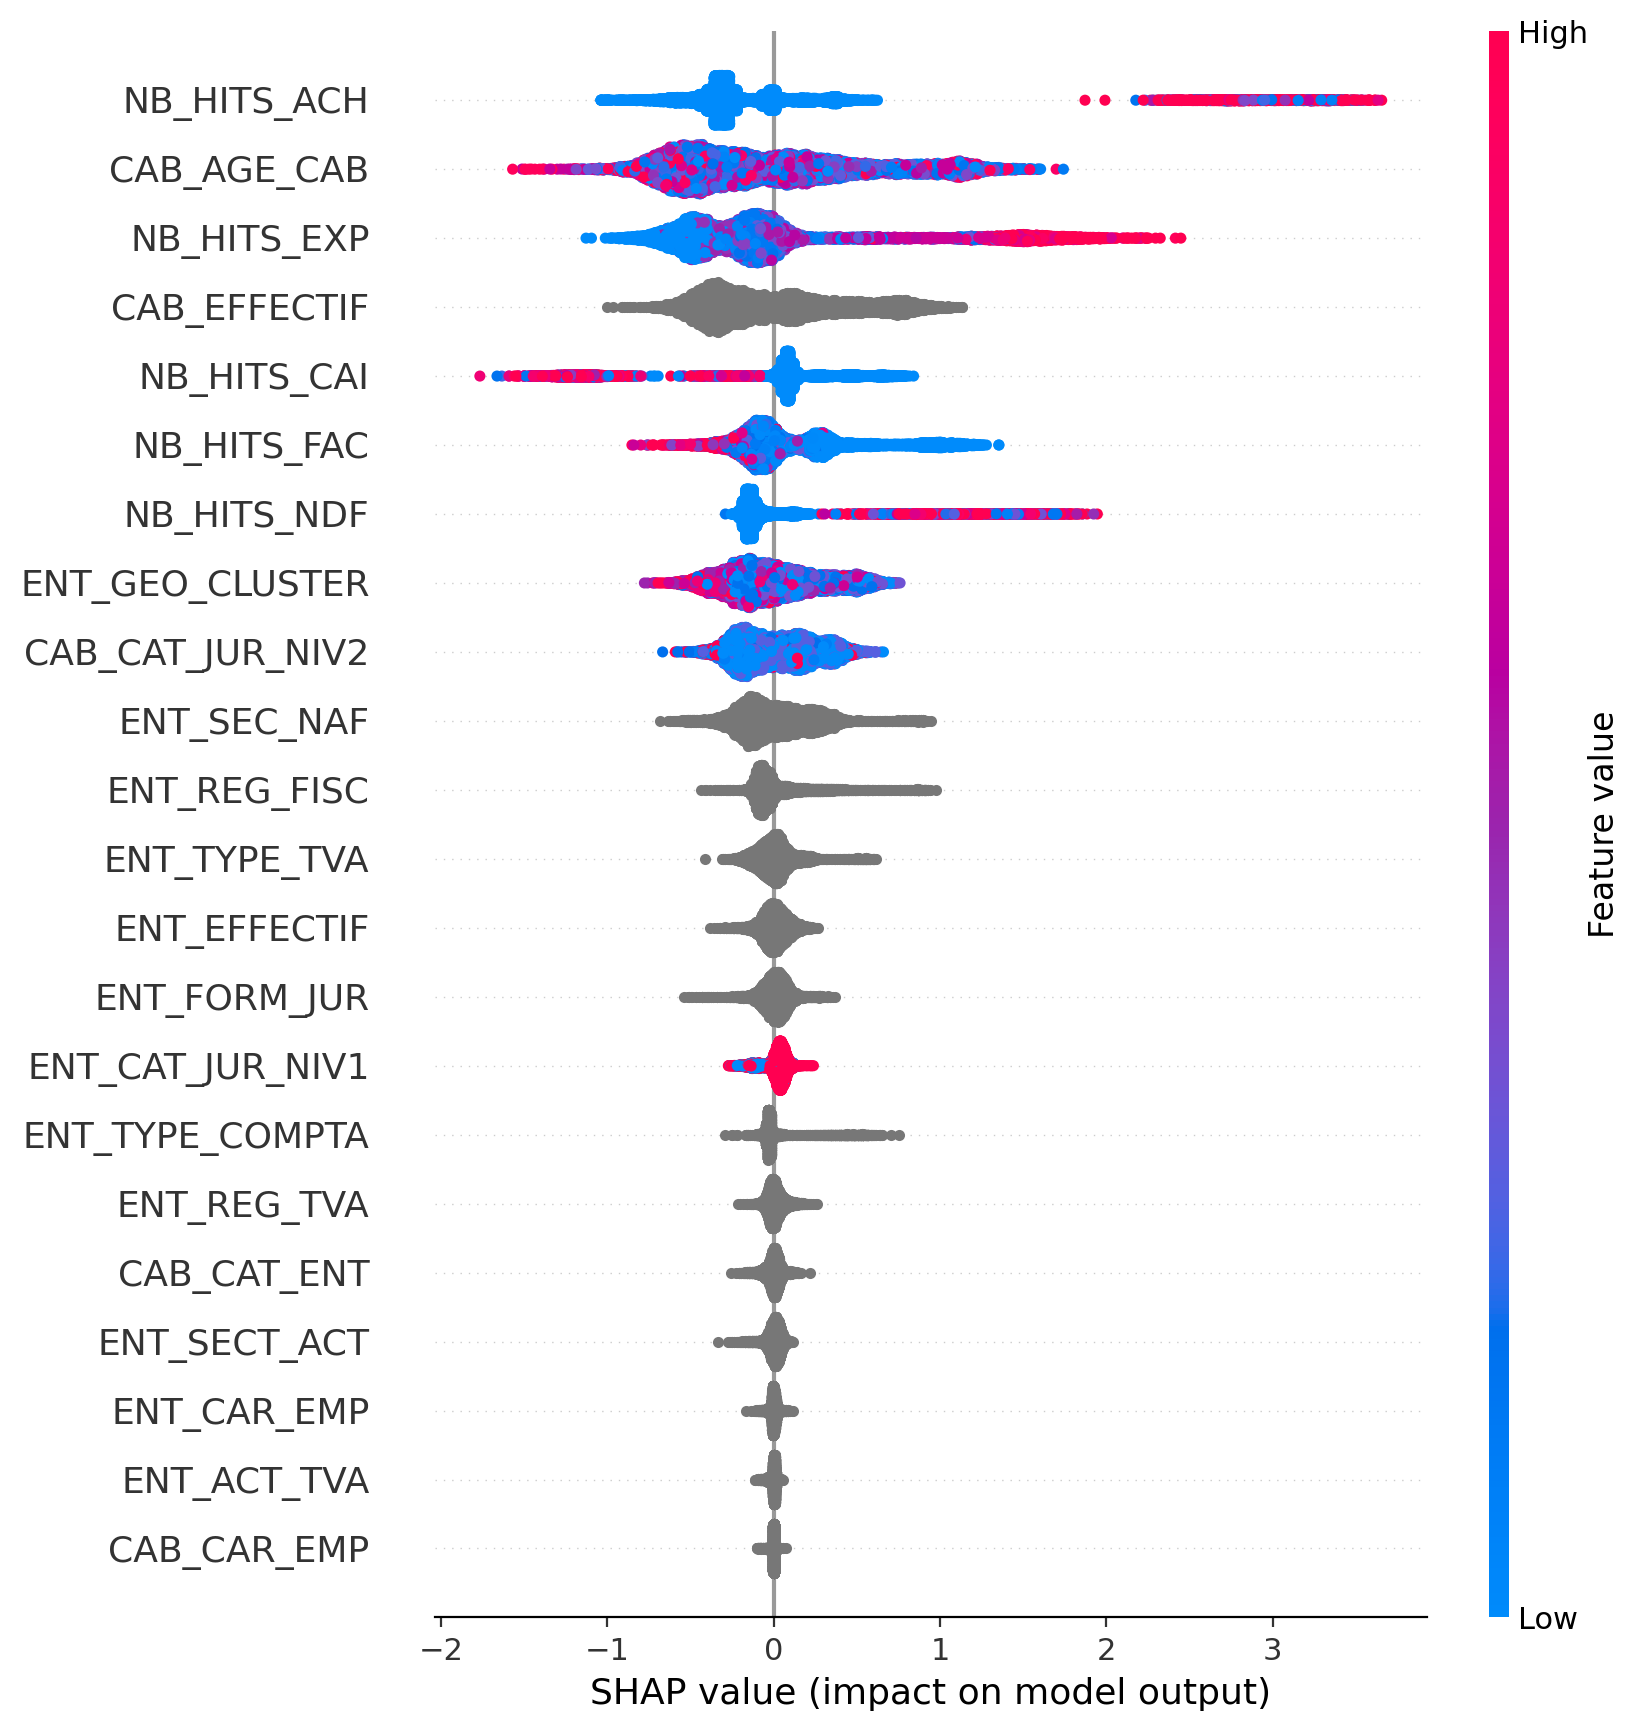

In [ ]:
plt.figure(figsize=(12, 12), dpi=100)
shap.plots.beeswarm(cb_shap, max_display=30, show=False)
plt.show()

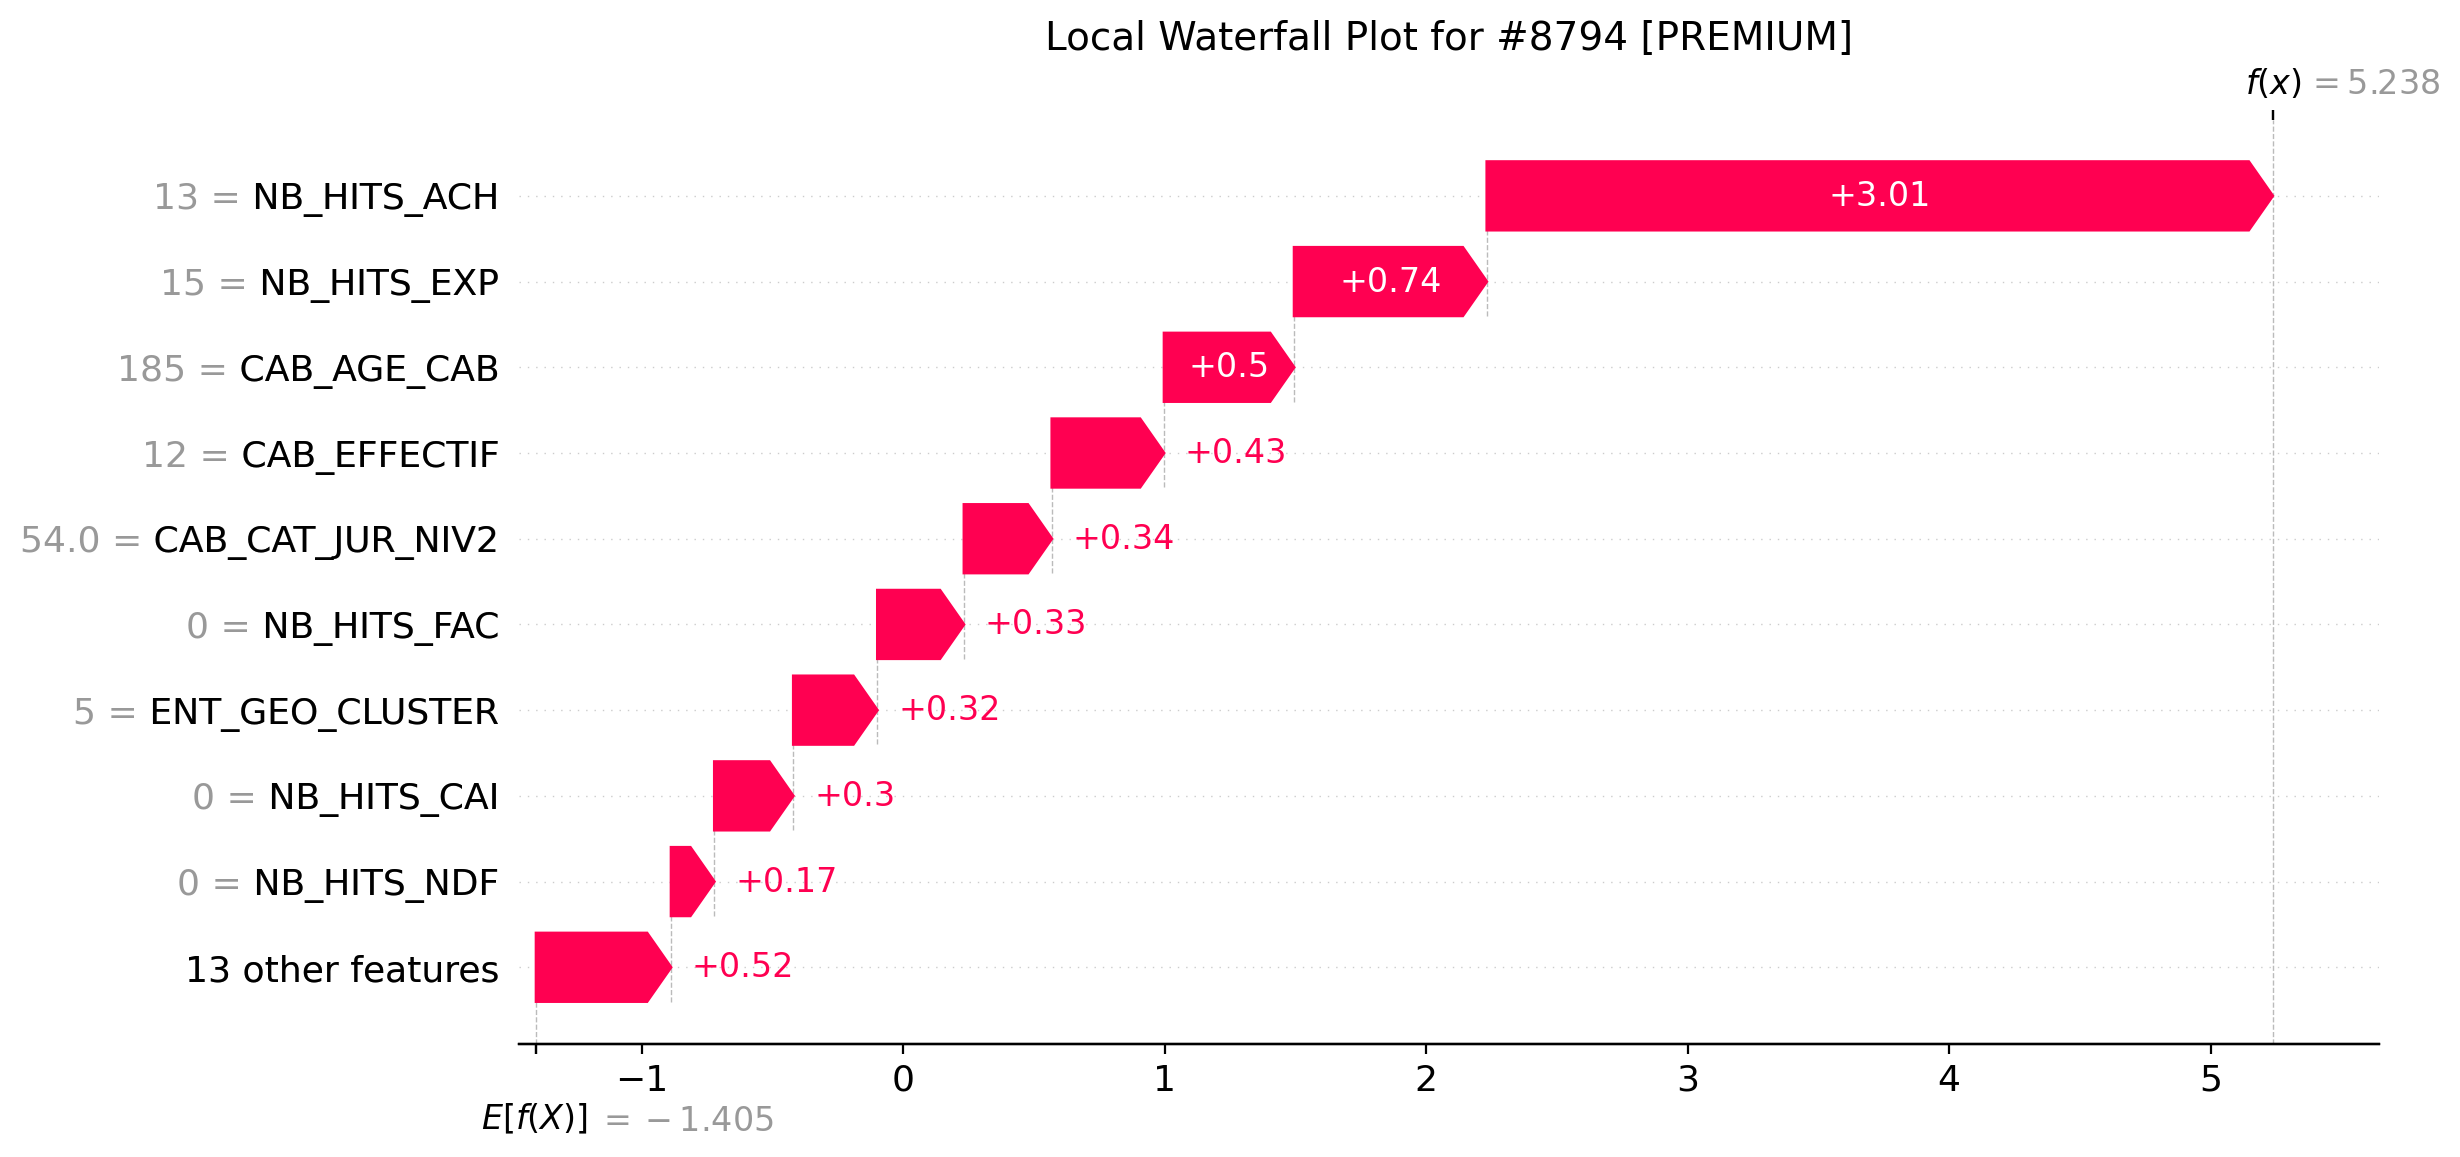

In [ ]:
shap.plots.waterfall(cb_shap[8798], show=False)
plt.gcf().set_size_inches(12, 6)
plt.title('Local Waterfall Plot for #8794 [PREMIUM]', fontsize=14)
plt.show()

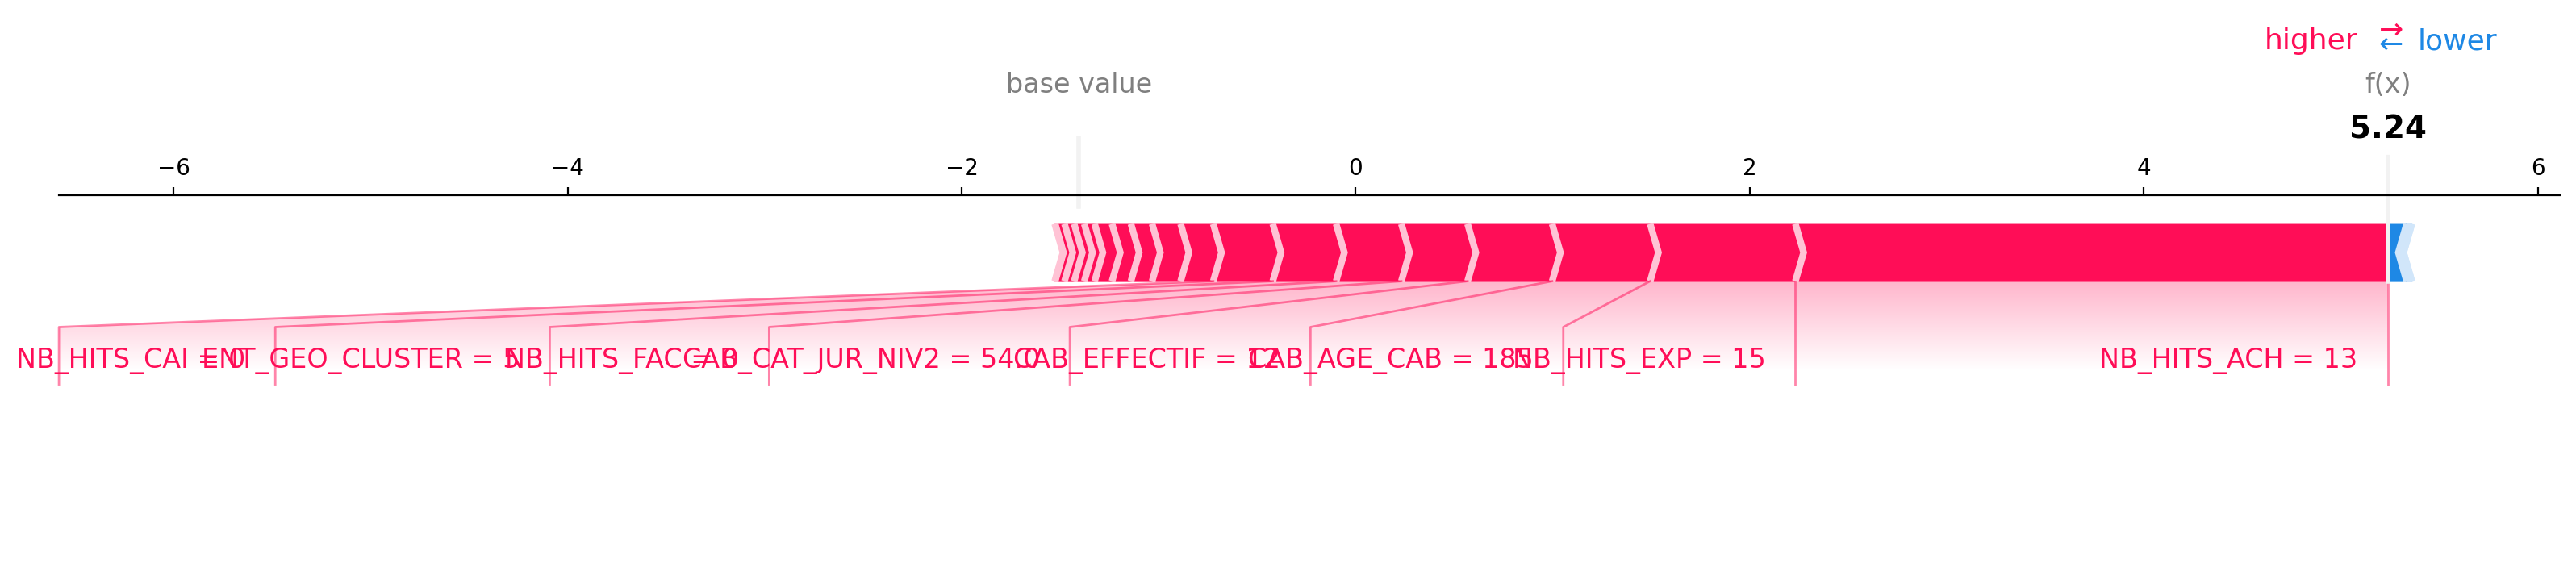

In [ ]:
shap.plots.force(cb_shap[8798], matplotlib=True)

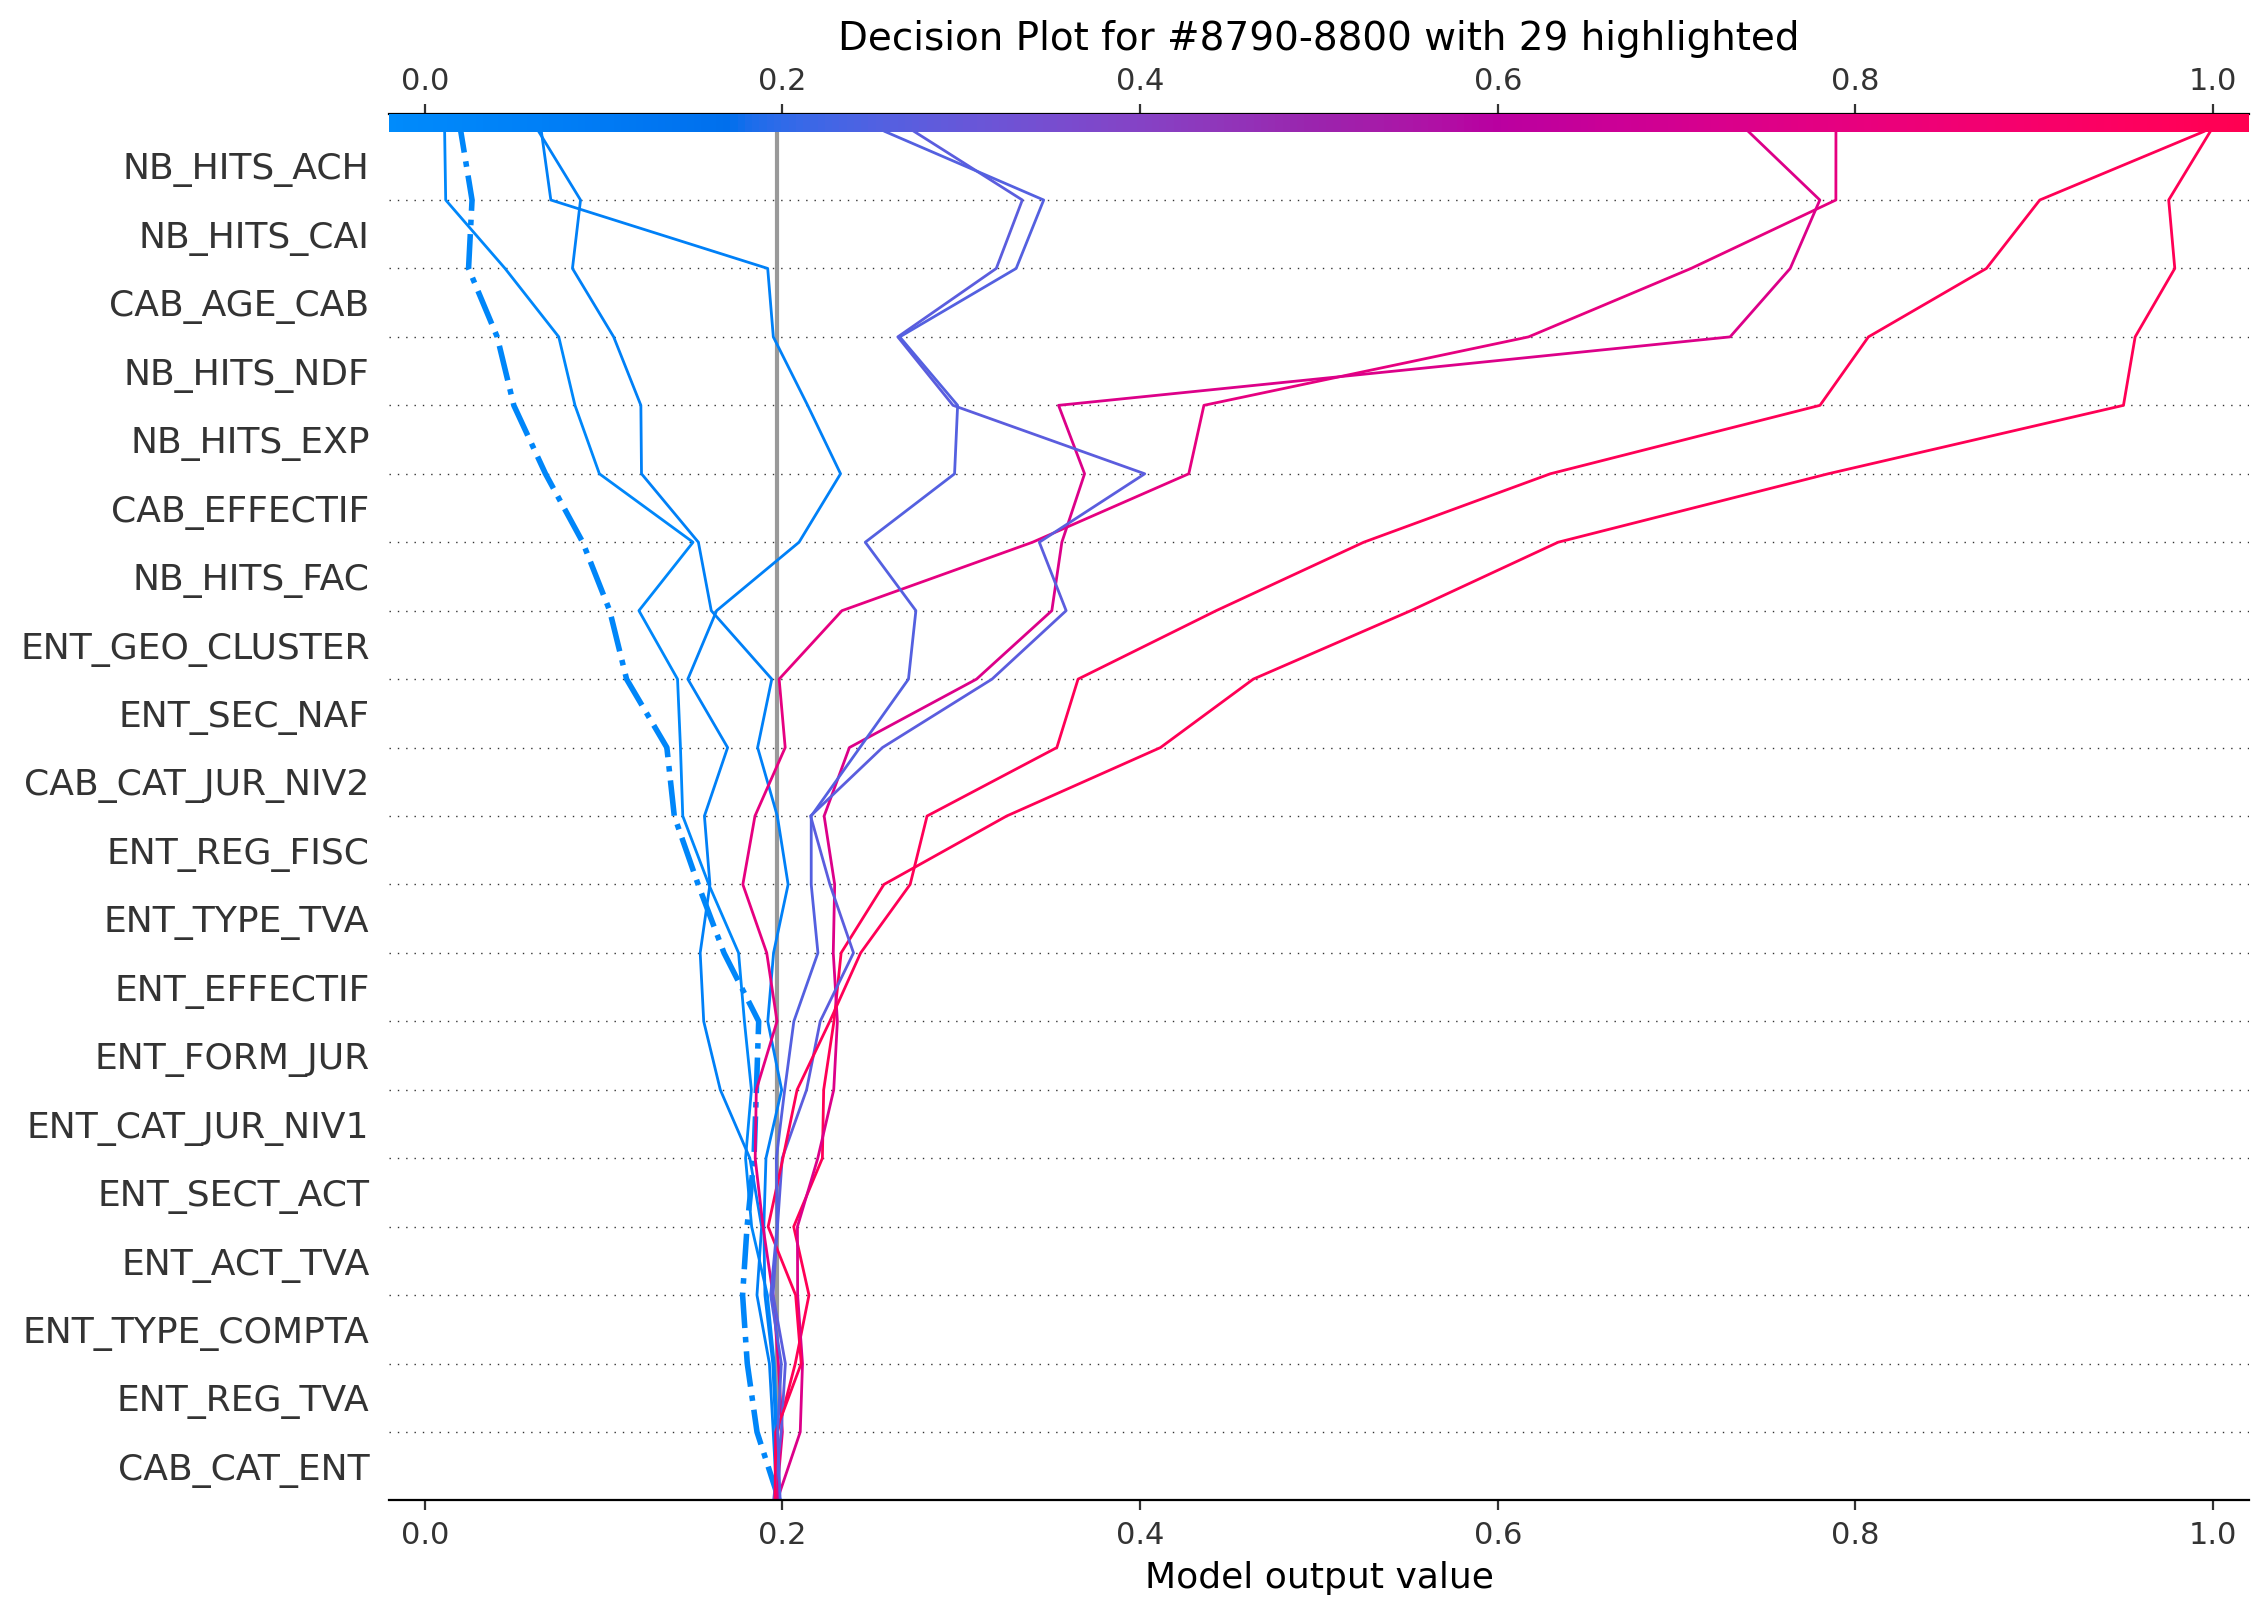

In [ ]:
shap.decision_plot(explainer.expected_value, cb_shap.values[8790:8800], X_test.iloc[8790:8800], highlight=4,\
                   show=False, link='logit')
plt.gcf().set_size_inches(12, 9)
plt.title('Decision Plot for #8790-8800 with 29 highlighted', fontsize=14)
plt.show()

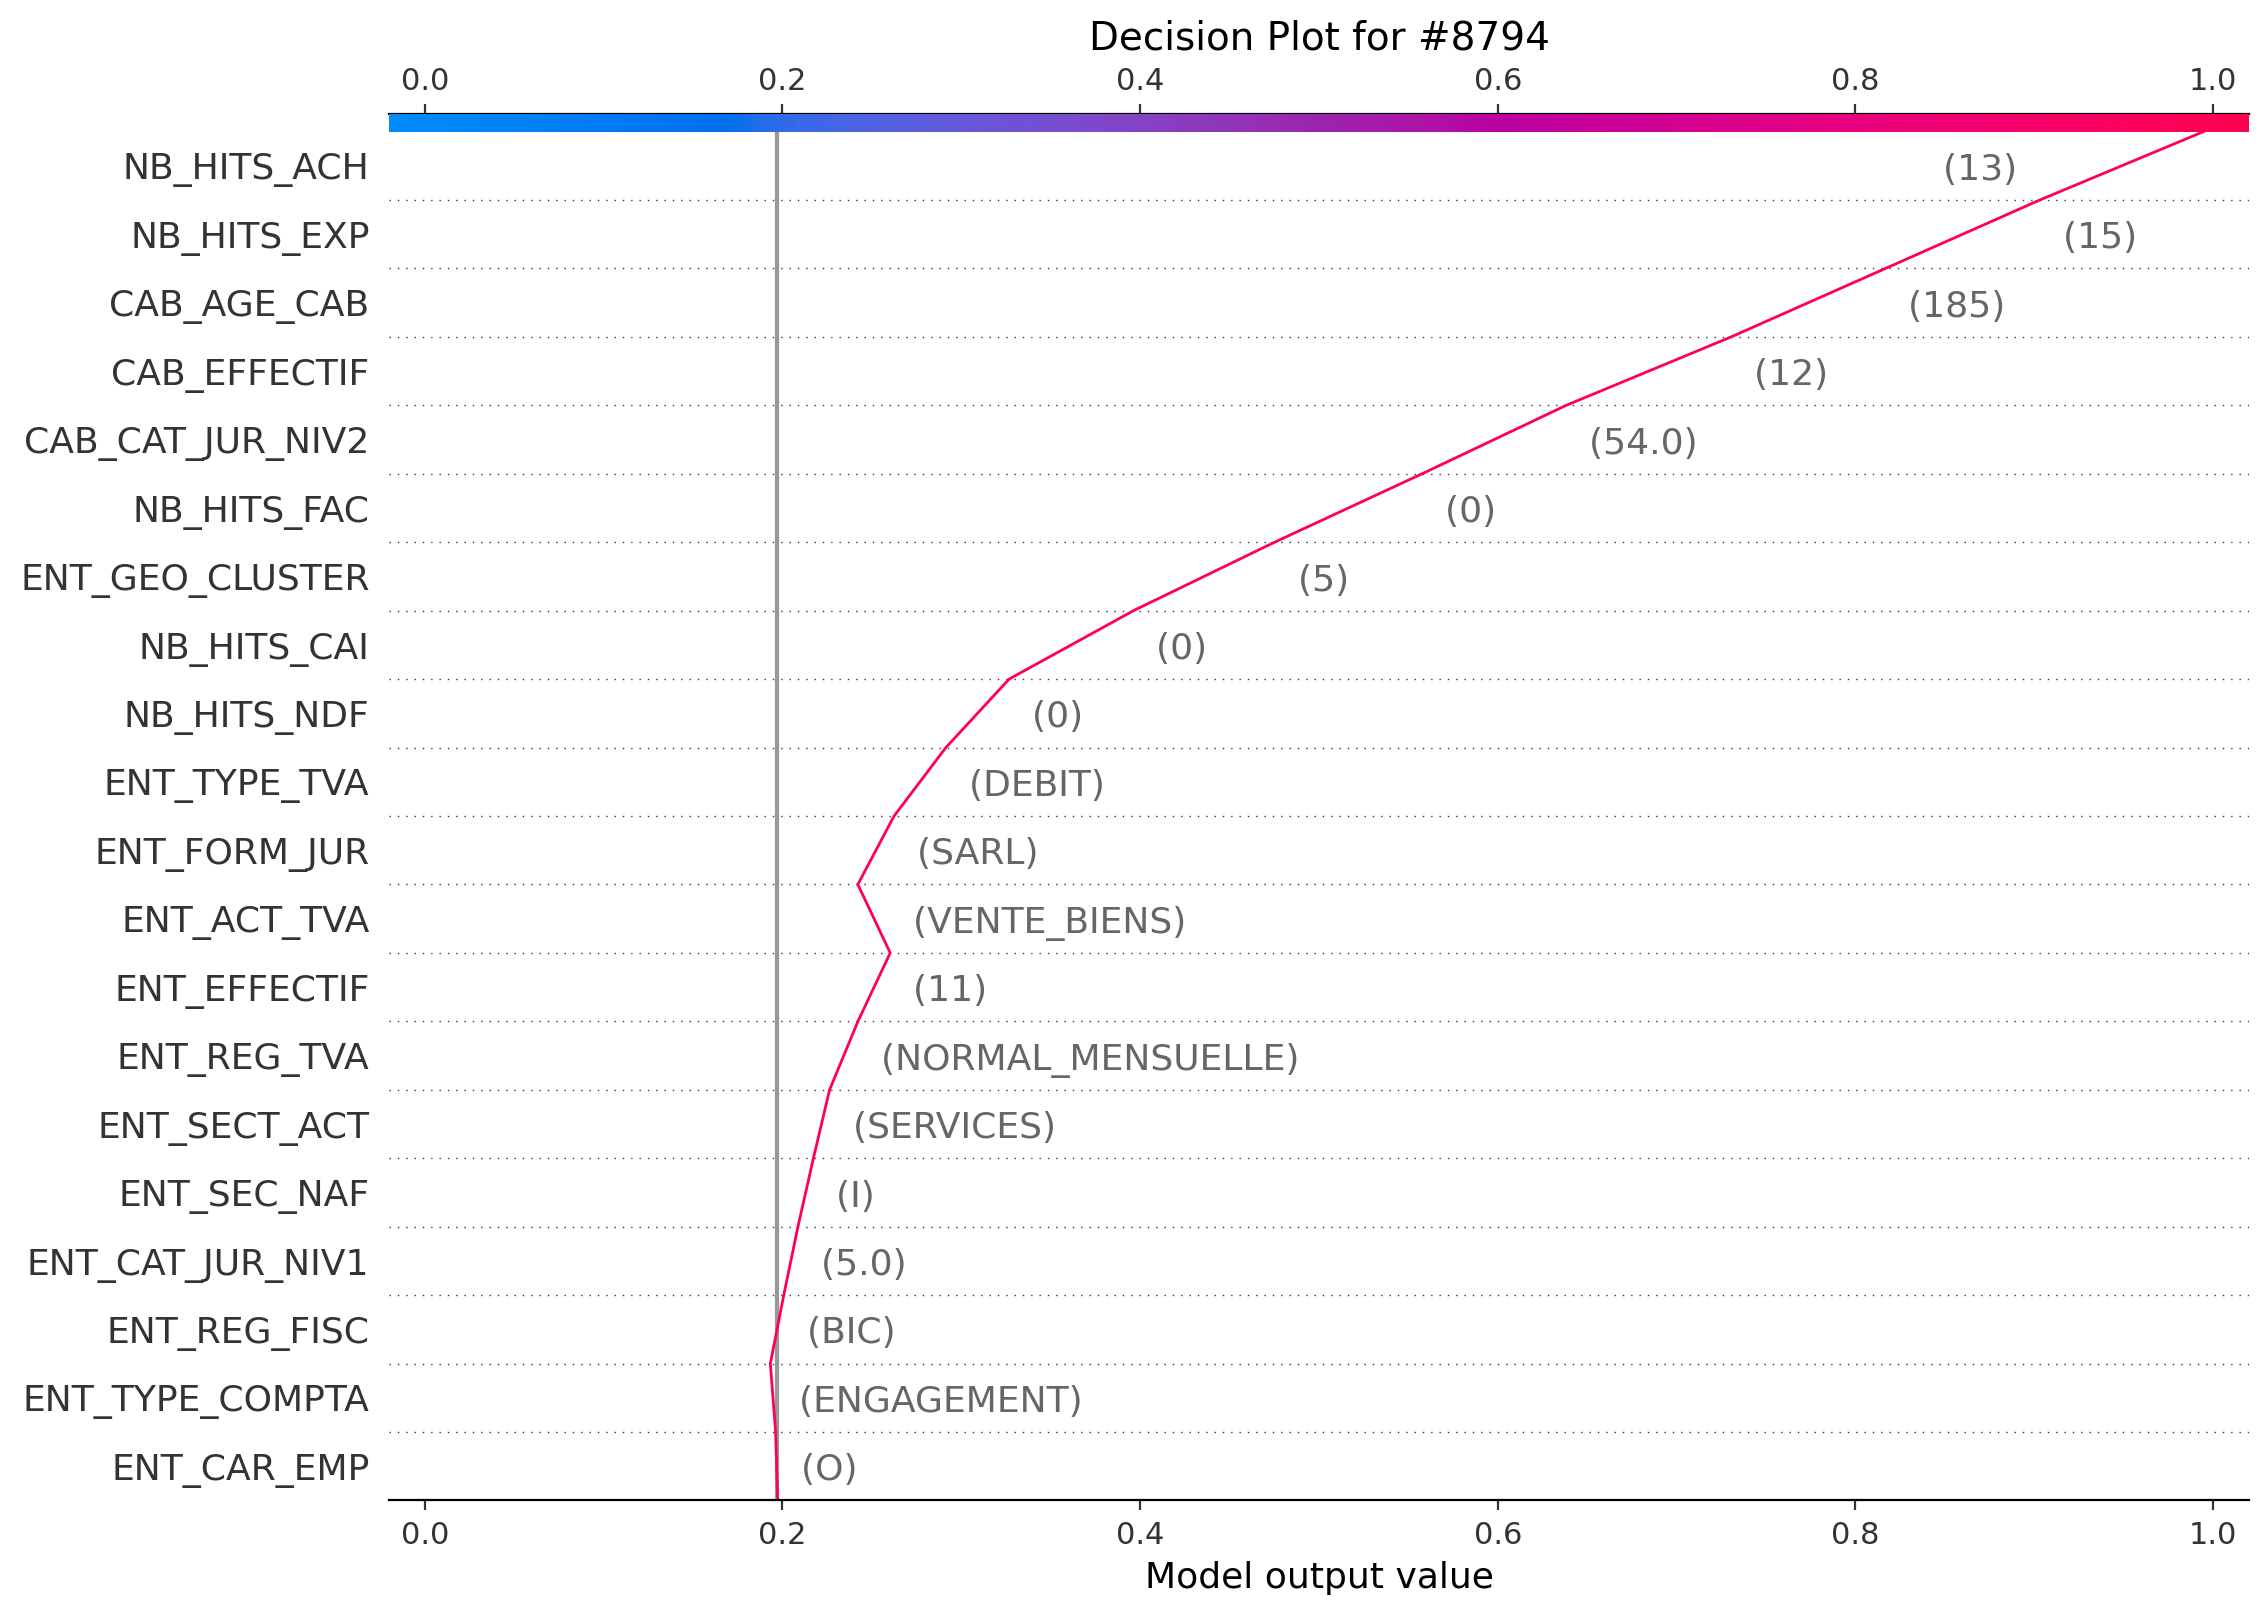

In [ ]:
shap.decision_plot(explainer.expected_value, cb_shap.values[8798], X_test.iloc[8798],\
                   show=False, link='logit')
plt.gcf().set_size_inches(12, 9)
plt.title('Decision Plot for #8794', fontsize=14)
plt.show()

In [ ]:
shap.decision_plot(explainer.expected_value, cb_shap.values, X_test,feature_order='hclust'
                   show=False, link='logit')
plt.gcf().set_size_inches(12, 9)
plt.title('Decision Plot for #8794', fontsize=14)
plt.show()

SyntaxError: ignored

In [ ]:
m.feature_importances_

array([16.58368068,  9.22571923,  7.96015653,  3.46593034,  7.04420853,
        5.3487619 ,  8.77307225,  1.57058577,  2.66908568,  2.29794921,
        0.22824466,  1.86599423,  1.68310088,  1.49030314,  4.10161331,
        0.5615031 ,  7.48558338,  1.97847733,  8.30911258,  1.53596332,
        0.14774486,  5.6732091 ])

In [ ]:
print("Values dimensions: %s" % (cb_shap.values.shape,)) 
print("Data dimensions:   %s" % (cb_shap.data.shape,))

Values dimensions: (11219, 22)
Data dimensions:   (11219, 22)


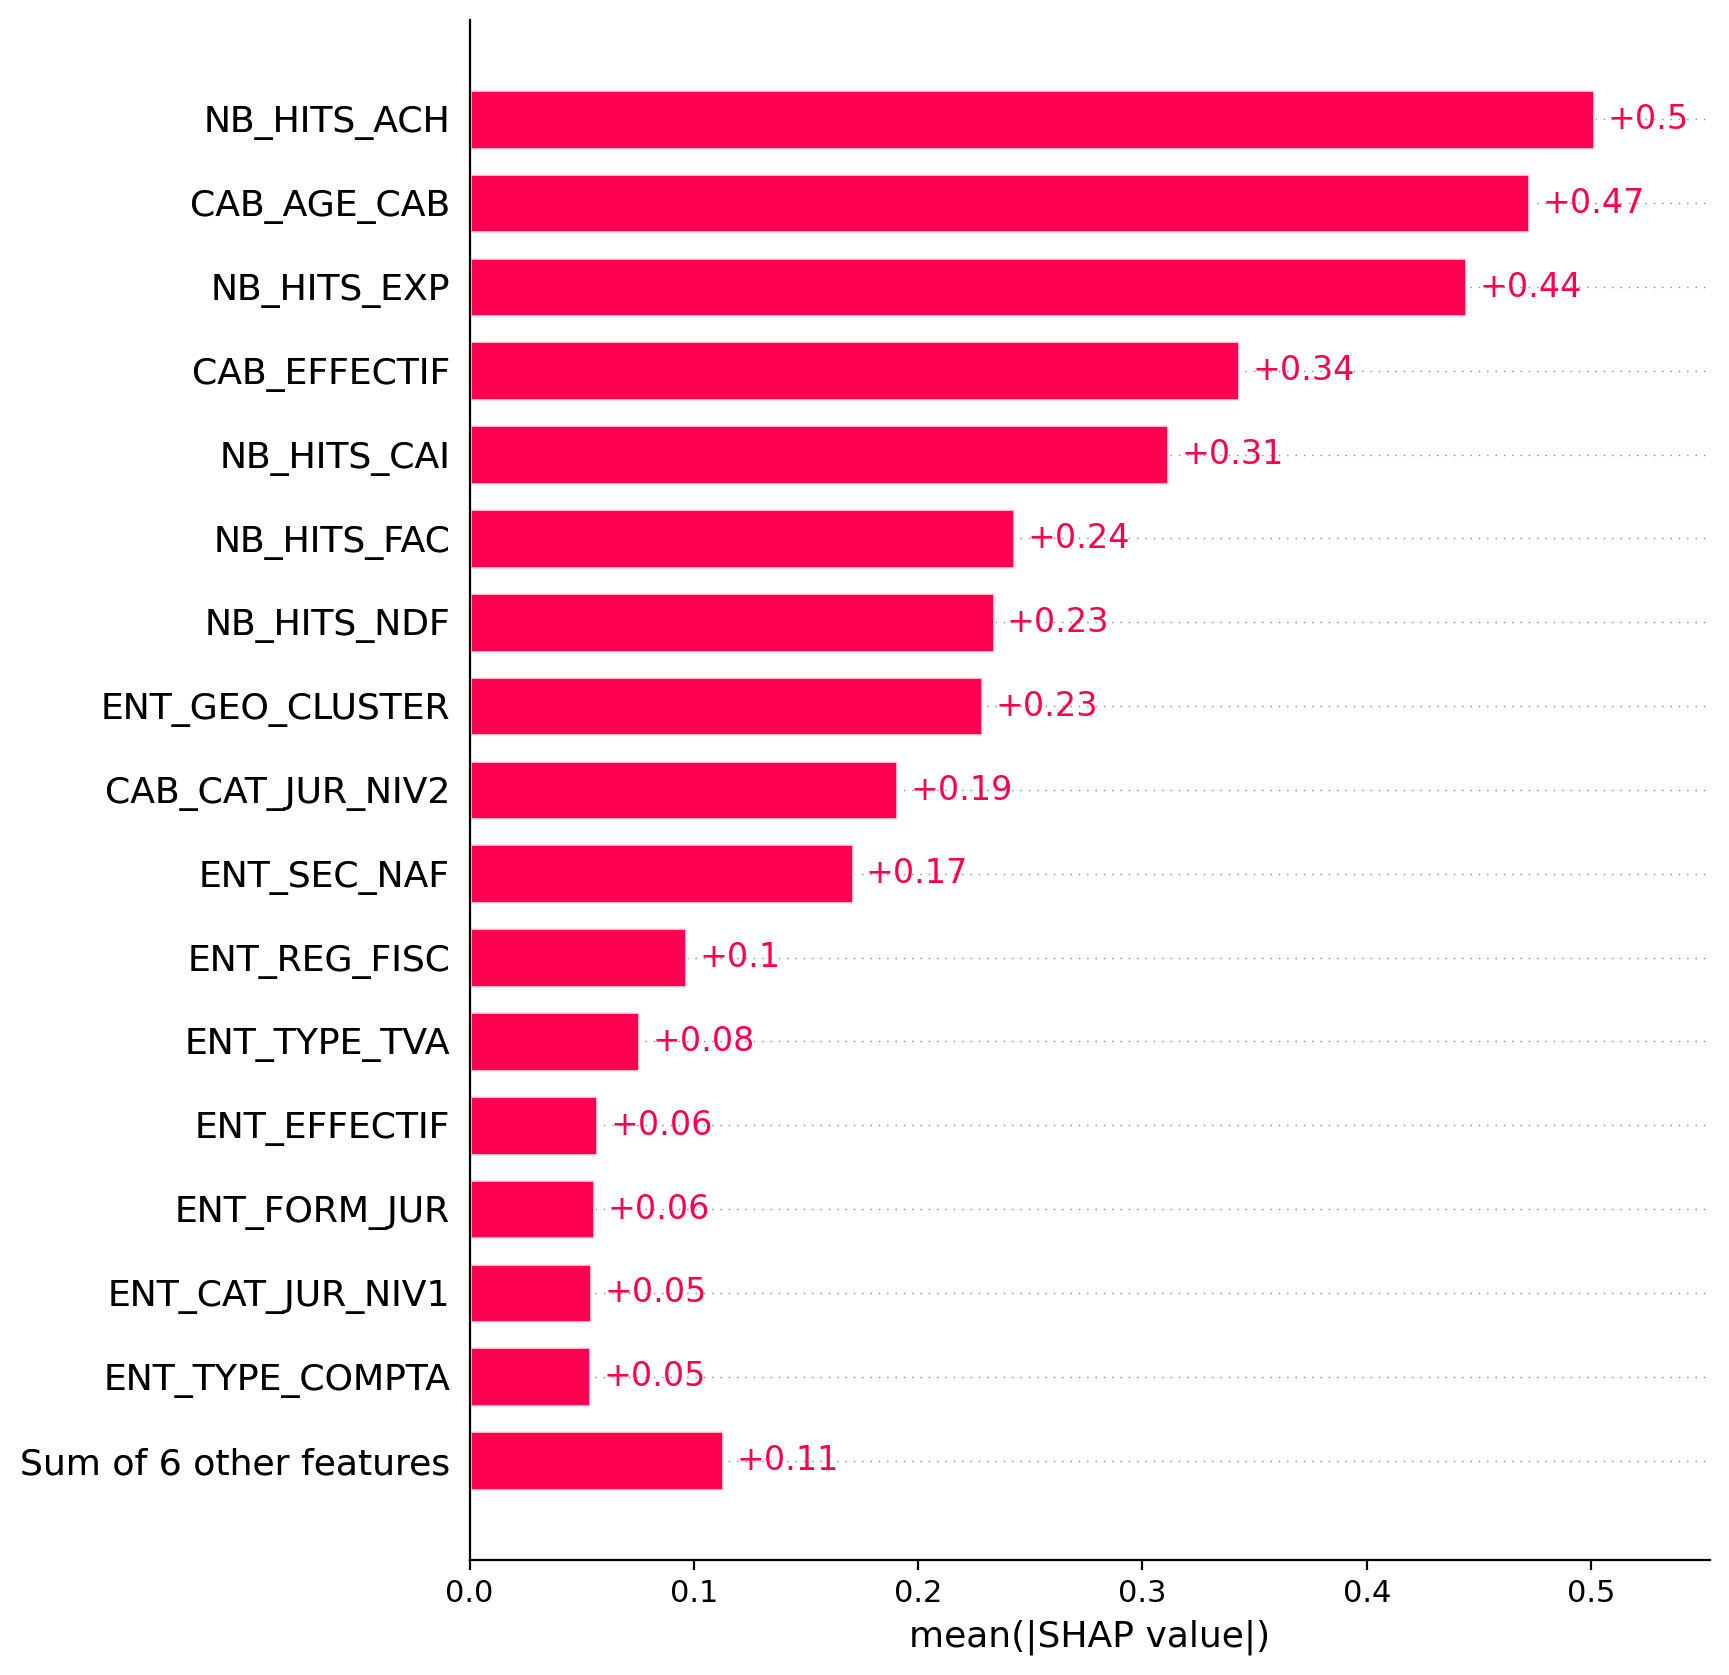

In [ ]:
plt.figure(figsize=(12, 12), dpi=100)
shap.plots.bar(cb_shap, max_display=17, show=False)
plt.show()

👩🏼‍💻 Now that we have preprocessed our dataset, let's evaluate a classification model, the Logistic Regression.

# 🃏 Feature Permutation
> Feature Permutation is a feature selection "algorithm" which evaluates the importance of each feature in predicting the target.
How does Feature Permutation work?

Your Turn! 🚀

How does Feature Permutation work?

1️⃣ 🥋 Trains a base model containing all the features and records the test score.

2️⃣ 🎲 Permutation Randomly shuffles a feature within the test set.

3️⃣ 🆕 Records the new score on the test set with the shuffled feature

4️⃣ 🕵🏻 Compares the new score to the original score. If the score dropped significantly, it means that this feature is important and that we shouldn't have shuffled it!

5️⃣ 🔁 Repeat steps 2-3-4 for each feature.

📚 sklearn.inspection.permutation_importance